## Table of Contents:

* [Introduction](#Introduction)
* [Import Libraries](#import-libraries)
* [Selecting a Single Stock](#selecting_a_single_stock)
* [KPSS Test for Stationarity Test](#kpss)
* [ADF Test for Stationarity Test](#adf)
* [Selecting the Order of Differencing(d)](#d)
* [Selecting the Order of AR(p)](#p)
* [Selecting the Order of MA(q)](#q)
* [Fitting the ARIMA model](#fit)
* [Residual Plot](#resid)
* [Auto ARIMA Forecasting using PMDARIMA](#auto)
* [Fitting the Prophet model](#fit)
* [OUT-Of-Sample Forecast](#OUT)
* [Comparison of MAPE Plot ](#MAPE)
* [Summary across all the Consumer Companies](#sum)





## Introduction <a class="anchor" id="Introduction"></a>

ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.
In this post, we build an optimal ARIMA model from scratch and later in this post we have used PMDARIMA and Prophet to 
build the ARIMA model automatically.

## Importing the necessary libraries <a class="anchor" id="import-libraries"></a>

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
import re
import csv
import warnings
import numpy as np
import pickle
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,plot_predict
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima as pm
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import fbprophet
from prophet import Prophet
import pandas as pd
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
#import pandas_market_calendars as mcal
#import requests
#from bs4 import BeautifulSoup
from sklearn import datasets, linear_model, metrics
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import time

## Picking a single stock data<a class="anchor" id="selecting_a_single_stock"></a>

In [2]:
with open('cons_cyc_df_years.pickle', 'rb') as handle:
    cons_cyc_df_years = pickle.load(handle)
cons_cyc_df_years

{'AAN':               Open    High     Low   Close     Volume  Daily_Returns
 2006-01-03  13.900  14.276  13.617  14.187   462513.0       0.029237
 2006-01-04  14.196  14.206  13.900  13.998   327965.0      -0.013322
 2006-01-05  13.968  13.978  13.784  13.803   231487.0      -0.013931
 2006-01-06  13.940  14.058  13.705  14.058   325213.0       0.018474
 2006-01-09  14.078  14.412  14.038  14.325   780383.0       0.018993
 ...            ...     ...     ...     ...        ...            ...
 2017-11-06  36.280  36.570  35.570  35.590  1029506.0      -0.023058
 2017-11-07  35.720  35.720  34.290  34.440  1149793.0      -0.032312
 2017-11-08  35.510  36.090  34.800  35.990  1805497.0       0.045006
 2017-11-09  35.680  35.860  35.230  35.620   979951.0      -0.010281
 2017-11-10  37.600  38.060  36.260  36.590  1214968.0       0.027232
 
 [2987 rows x 6 columns],
 'ANF':               Open    High      Low   Close     Volume  Daily_Returns
 2006-01-03  54.419  54.938  53.6180  54.186  3

In [3]:
amazon_cl = cons_cyc_df_years['AMZN'][['Close']]
amazon_return = cons_cyc_df_years['AMZN'][['Daily_Returns']]
amazon_cl

Close
2006-01-03    47.58
2006-01-04    47.25
2006-01-05    47.65
2006-01-06    47.87
2006-01-09    47.08
...             ...
2017-11-06  1120.66
2017-11-07  1123.17
2017-11-08  1132.88
2017-11-09  1129.13
2017-11-10  1125.35

[2987 rows x 1 columns]

## KPSS test for stationarity<a class="anchor" id="kpss"></a>

KPSS is test to check for stationarity in the presence of a deterministic trend. 

Null Hypothesis(H0): Time series is stationary around a deterministic trend. 

Alternative Hypothesis(Ha): Time series has unit root, i.e., non-statinary. 

In [4]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return (kpss_output)

df = kpss_test(amazon_cl.values)
df1 = kpss_test(amazon_return.values)
print (df, df1)

Results of KPSS Test:
Results of KPSS Test:
Test Statistic            1.70966
p-value                   0.01000
Lags Used                32.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64 Test Statistic            0.031492
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The p-value reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.
So, here we can say that amazon closing price is not stationary(rejecting the H0) and for amazon return price, we fail to reject the null hypothesis, i.e., time series is sationatinary. 


## ADF test for stationarity<a class="anchor" id="adf"></a>

ADF test is for checking the stationarity.
H0: The null hypothesis of the ADF test is that the time series is non-stationary.
Ha: The alternative hypothesis of the ADF test is that the time series is stationary.     

In [5]:
result_closing = adfuller(amazon_cl.values)
result_return = adfuller(amazon_return.values)

print (result_closing)
print (result_return)

(2.9097423703974257, 1.0, 29, 2957, {'1%': -3.432563387143659, '5%': -2.8625179291294662, '10%': -2.5672905782716513}, 19642.916397494984)
(-41.231323939010906, 0.0, 1, 2985, {'1%': -3.432542607157588, '5%': -2.8625087513967085, '10%': -2.5672856921402096}, -13356.91284047806)


## How to find the order of differencing (d)<a class="anchor" id="d"></a>

The purpose of differencing it to make the time series stationary. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.



<Figure size 432x288 with 0 Axes>

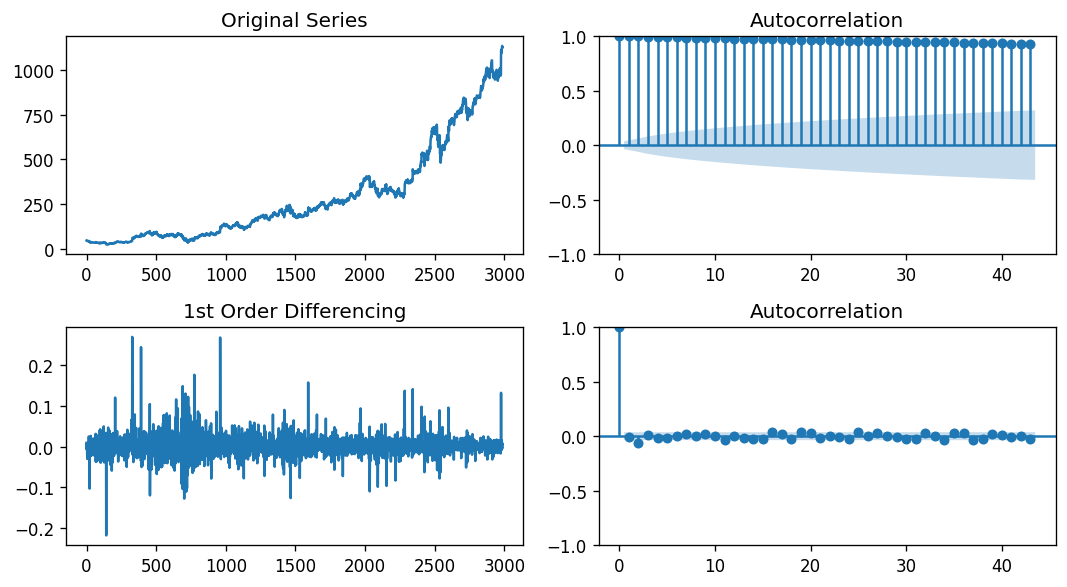

In [6]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(amazon_cl.values)
axes[0, 0].set_title('Original Series')
#plot_acf(amazon_cl.values, ax=axes[0, 1])
sm.graphics.tsa.plot_acf(amazon_cl.values, ax=axes[0, 1], lags = 43)

# 1st Differencing
axes[1, 0].plot(amazon_return.values)
axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(amazon_return.values, ax=axes[1, 1], lags = 43)
fig.tight_layout()
plt.show()

From the stationarity tests (KPSS and ADF) and the correlation plots above, it can be said that 
closing price of Amazon stock price is not stationary. However, after first differencing (daily returns), it looks like the stock price follows stationarity.
So, it seems like differencing(d) = 1 will serve the purpose, i.e., data follows the stationarity.

## How to find the order of AR term (p)<a class="anchor" id="p"></a>

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1080x600 with 0 Axes>

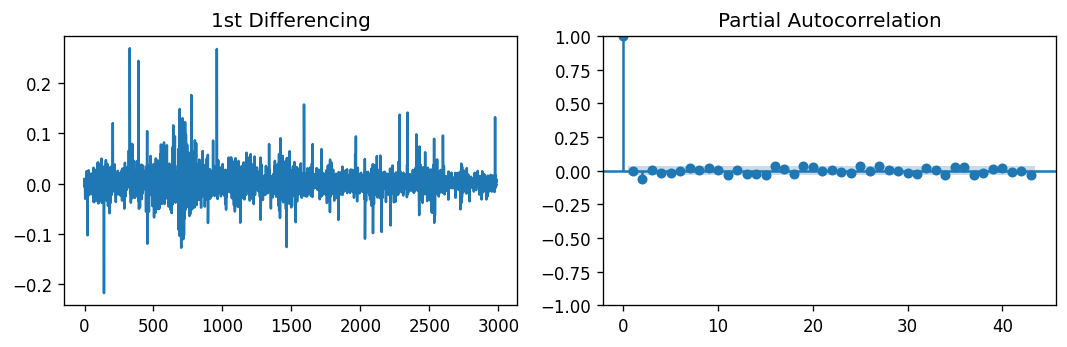

In [7]:
plt.clf()
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(amazon_return.values)
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_pacf(amazon_return.values, ax = axes[1], lags = 43)
fig.tight_layout()
plt.show()

You can observe that the PACF lag 2 is slightly significant, just managing to cross the significance limit (blue region). So, lets start with p as 2.

## How to find the order of MA term (q)<a class="anchor" id="q"></a>

Just like how we looked at the PACF plot for the number of AR terms, we can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
From the above ACF plot, it does not seem like there is any significant lags. However, there 
is a very small lag appears to be minutely significant at lag = 2. 
So, lets start to model with (2,1,2) order and then we will play around and see which model fits the best. 


## Building ARIMA model<a class="anchor" id="fit"></a>

Now that the values of p, d and q have been determined, next we can fit the ARIMA model. 

In [8]:
model = ARIMA(amazon_cl, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2987
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9911.621
Date:                Fri, 08 Apr 2022   AIC                          19833.243
Time:                        00:24:39   BIC                          19863.251
Sample:                             0   HQIC                         19844.039
                               - 2987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0708      0.162      6.599      0.000       0.753       1.389
ar.L2         -0.5176      0.172     -3.016      0.003      -0.854      -0.181
ma.L1         -1.0466      0.165     -6.332      0.0

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under 'coef' are the weights of the respective terms.

Notice here the coefficient of all the terms are significant and the P-Value in 'P>|z|' column is highly significant (<0.05).


In [11]:
import seaborn as sns
sns.set()
def arima_model_eval_baseline(data, arima_order):
    #baseline_rmse_list = []
    #baseline_mape_list = []
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 =  data[split:]
    # walk-forward validation
    history = [x for x in train1]
    predictions = []
    for i in range(len(test1)):
    # predict
        yhat = history[-1]
        predictions.append(yhat)
    # observation
        obs = test1[i]
        history.append(obs)
        
# report performance
    mse = mean_squared_error(test1, predictions)
    baseline_rmse = np.sqrt(mse)
    baseline_mape = np.mean(np.abs(test1 - predictions)/np.abs(test1))
    #print('RMSE: %.3f' % rmse,  'MAPE: %.3f' % mape)
    baseline_rmse_list = ((np.square(np.subtract(test1,predictions))))
    baseline_mape_list = (np.abs(test1 - predictions)/np.abs(test1))
    baseline_rmse_list = list(map(lambda x :x[0], baseline_rmse_list))
    baseline_mape_list = list(map(lambda x :x[0], baseline_mape_list))
    #print (np.mean(baseline_rmse_list))
    #print (baseline_rmse_list)
    #sns.distplot(baseline_mape_list, color = 'maroon', kde = True)#kind = 'kde'
    return (baseline_mape_list, baseline_rmse, baseline_mape)
    
baseline_model = arima_model_eval_baseline(amazon_cl.values, (2,1,2))


/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


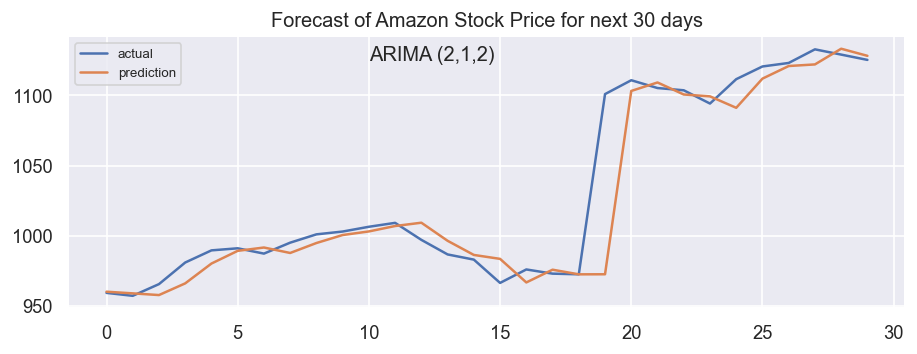

In [10]:
def arima_model_eval_manual(data, arima_order):
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 = data[split:len(data)]
    history = [x for x in train1]
    prediction = []
    for i in range(len(test1)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        warnings.simplefilter('ignore', ConvergenceWarning)
        model_forecast = model_fit.forecast()
        prediction.append(model_forecast[0])
        obs = test1[i]
        history.append(obs)
    test1 = np.array(list(map(lambda x: x[0], test1)))
    prediction = np.array(prediction)
    mse = mean_squared_error(test1,prediction)
    arima_rmse = np.sqrt(mse)
    arima_mape = np.mean(np.abs(test1 - prediction)/np.abs(test1))
    arima_rmse_list = ((np.square(np.subtract(test1,prediction))))
    arima_mape_list = (np.abs(test1 - prediction)/np.abs(test1))
    #arima_rmse_list = list(map(lambda x :x[0], arima_rmse_list))
    #arima_mape_list = list(map(lambda x :x[0], arima_mape_list))
    plt.plot(test1, label = 'actual') 
    plt.plot(prediction, label = 'prediction') 
    plt.title('Forecast of Amazon Stock Price for next 30 days')
    plt.legend(loc='upper left', fontsize=8)
    plt.text(10,1125,'ARIMA (2,1,2)', fontsize = 12)
    plt.show()
    return (arima_mape_list, arima_rmse, arima_mape)
arima_model = arima_model_eval_manual(amazon_cl.values, (2,1,2))

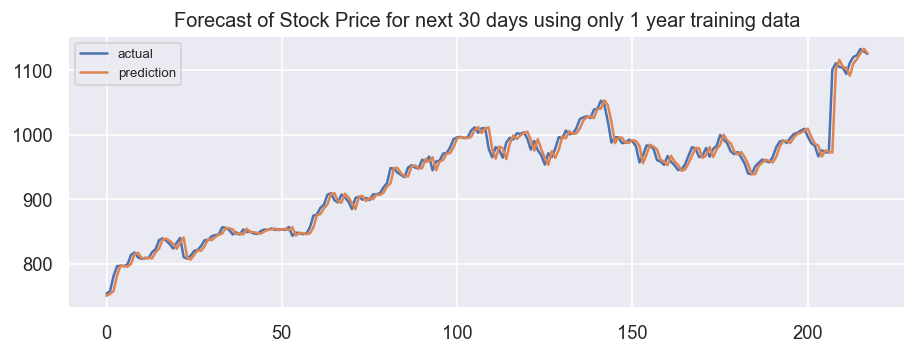

RMSE: 13.131 MAPE: 0.008


In [13]:
amazon_cl_15_17 = amazon_cl.loc[pd.to_datetime('2015'):pd.to_datetime('2018')]
amazon_cl_15_17_list = list(map(lambda x: x[0],amazon_cl_15_17.values.tolist()))
train_size = amazon_cl_15_17.loc[pd.to_datetime('2015'):pd.to_datetime('2017')].shape[0]
train_list = amazon_cl_15_17_list[:train_size]
test_list = amazon_cl_15_17_list[train_size:]
pred = []

for i in range(len(test_list)):
    arima_model = ARIMA(train_list,order = (2,1,2))
    fitted = arima_model.fit()
    warnings.simplefilter('ignore', ConvergenceWarning)
    forecast = fitted.forecast()
    pred.append(forecast[0])
    del train_list[0]
    train_list.append(test_list[i])
    
plt.plot(test_list, label = 'actual') 
plt.plot(pred, label = 'prediction') 
plt.title('Forecast of Stock Price for next 30 days using only 1 year training data')
plt.legend(loc='upper left', fontsize=8)
plt.show()
    
rmse_metric = np.sqrt(mean_squared_error(test_list,pred))
mape_metric = np.mean(np.abs(np.array(test_list) - np.array(pred))/np.abs(np.array(test_list)))
print('RMSE: %.3f' % rmse_metric,  'MAPE: %.3f' % mape_metric)

## Residual plot<a class="anchor" id="resid"></a>

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

                0
count   30.000000
mean     5.919072
std     24.466823
min    -17.144675
25%     -3.228097
50%      2.219549
75%      7.770203
max    128.486837


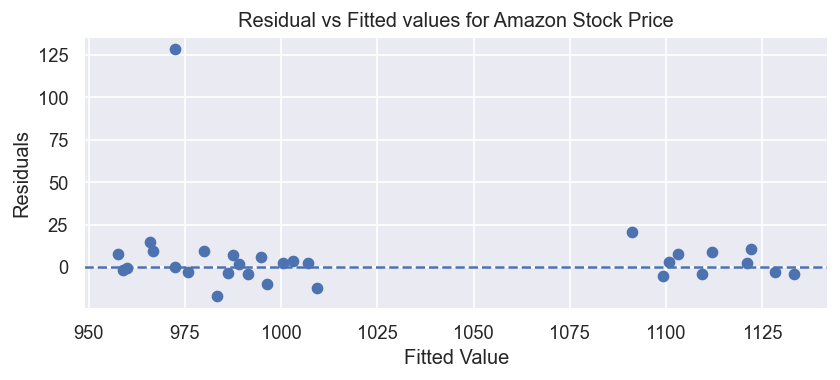

In [14]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':120})

def arima_model_eval(data, arima_order):
    split = int(len(data) * 0.99)
    train1 = data[0:split]
    test1 = data[split:len(data)]
    history = [x for x in train1]
    prediction = []
    for i in range(len(test1)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit()
        warnings.simplefilter('ignore', ConvergenceWarning)
        model_forecast = model_fit.forecast()
        prediction.append(model_forecast[0])
        obs = test1[i]
        history.append(obs)
    test1 = list(map(lambda x: x[0], test1))
    residuals = [test1[i]-prediction[i] for i in range(len(test1))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    residuals = list(map(lambda x: x[0], residuals.values))
    plt.scatter(prediction, residuals)
    plt.title('Residual vs Fitted values for Amazon Stock Price')
    plt.xlabel('Fitted Value')
    plt.ylabel('Residuals')
    plt.axhline(ls = '--')
    #plt.legend(loc='upper left', fontsize=8)
    plt.show()
arima_model_eval(amazon_cl.values, (2,1,2))

## Auto Arima Forecast in Python (PMDARIMA)<a class="anchor" id="auto"></a>

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19225.688, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19222.372, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19223.808, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19223.794, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19227.606, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.720 seconds


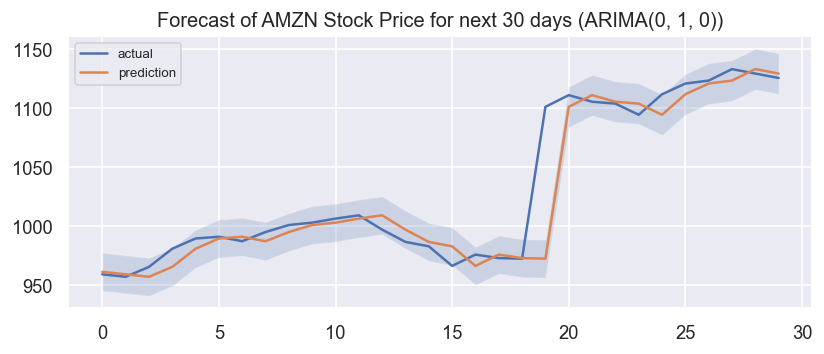

In [20]:
def pmdarima_model_eval(df, company_name):
    data = df.values
    split = int(len(data) * 0.99)
    train_pmdarima = data[0:split]
    train_pmdarima = list(map(lambda x: x[0],train_pmdarima))
    test_pmdarima = data[split:len(data)]
    test_pmdarima = list(map(lambda x: x[0],test_pmdarima))
    model_auto = pm.auto_arima(train_pmdarima, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                        stepwise=True)
    history_pmd = [x for x in train_pmdarima]
    pmd_prediction = []
    ci_underline = []
    ci_overline = []
    for i in range(len(test_pmdarima)):
        model = ARIMA(history_pmd, order = model_auto.order)
        model_fit = model.fit()
        model_result = model_fit.get_forecast(steps=1)
        model_forecast = model_result.predicted_mean
        pmd_prediction.append(model_forecast[0])
        obs = test_pmdarima[i]
        history_pmd.append(obs)
        ci = model_result.conf_int(alpha=0.01)
        ci_underline.append(ci[0][0])
        ci_overline.append(ci[0][1])
    ci_underline = np.array(ci_underline)
    ci_overline = np.array(ci_overline)
    
    rng = np.array([i for i in range(0,len(test_pmdarima))])
    test_pmdarima = np.array(test_pmdarima)
    pmd_prediction = np.array(pmd_prediction)
    mse = mean_squared_error(test_pmdarima,pmd_prediction)
    pmdarima_rmse = np.sqrt(mse)
    pmdarima_mape = np.mean(np.abs(test_pmdarima - pmd_prediction)/np.abs(test_pmdarima))
    pmdarima_rmse_list = ((np.square(np.subtract(test_pmdarima,pmd_prediction))))
    pmdarima_mape_list = (np.abs(test_pmdarima - pmd_prediction)/np.abs(test_pmdarima))
    #pmdarima_rmse_list = list(map(lambda x :x[0], arima_rmse_list))
    #pmdarima_mape_list = list(map(lambda x :x[0], arima_mape_list))
    plt.plot(rng,test_pmdarima, label = 'actual') 
    plt.plot(rng,pmd_prediction, label = 'prediction') 
    plt.title('Forecast of ' + company_name + ' Stock Price for next 30 days (ARIMA{})'.format(model_auto.order))
    plt.legend(loc='upper left', fontsize=8)
    plt.fill_between(rng, ci_underline,ci_overline, alpha=0.2 )
    plt.show()
    return (pmdarima_mape_list, pmdarima_rmse, pmdarima_mape)
    

pmdarima_model = pmdarima_model_eval(amazon_cl,'AMZN')


## Building Prophet model<a class="anchor" id="fit"></a>

## Make an Out-Of-sample Forecast <a class="anchor" id="OUT"></a>

In [301]:
"""
amazon_cl_15_17_pro = amazon_cl_15_17.copy()
amazon_cl_15_17_pro = amazon_cl_15_17_pro.loc[amazon_cl_15_17_pro.index.year == 2017]
amazon_cl_15_17_pro.reset_index(inplace=True)
amazon_cl_15_17_pro = amazon_cl_15_17_pro.rename(columns = {'index':'ds','Close':'y'})
amazon_cl_15_17_pro
"""

"\namazon_cl_15_17_pro = amazon_cl_15_17.copy()\namazon_cl_15_17_pro = amazon_cl_15_17_pro.loc[amazon_cl_15_17_pro.index.year == 2017]\namazon_cl_15_17_pro.reset_index(inplace=True)\namazon_cl_15_17_pro = amazon_cl_15_17_pro.rename(columns = {'index':'ds','Close':'y'})\namazon_cl_15_17_pro\n"

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -86.8346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9031.12      0.261814       9762.89           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9248.65     0.0478723       3335.78           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9399.91    0.00545629       1709.65           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9419.78    0.00027755       278.375           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        9444.5     0.0242538       2089.25           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2017-10-02  1014.739275   989.270981  1049.827360  1014.739275   
1  2017-10-03  1015.401637   992.001550  1051.545466  1015.401637   
2  2017-10-04  1016.063999   993.460464  1050.941775  1016.063999   
3  2017-10-05  1016.726361   993.470920  1055.050661  1016.726361   
4  2017-10-06  1017.388723   995.269471  1053.733591  1017.388723   
5  2017-10-09  1019.375809   994.635084  1058.508049  1019.375809   
6  2017-10-10  1020.038171   997.800387  1058.182159  1020.038171   
7  2017-10-11  1020.700533   997.213445  1056.970234  1020.700533   
8  2017-10-12  1021.362895   998.745267  1058.766188  1021.362895   
9  2017-10-13  1022.025257   997.136686  1059.350523  1022.025257   
10 2017-10-16  1024.012343  1000.344424  1061.842039  1024.012343   
11 2017-10-17  1024.674705  1003.033805  1060.944968  1024.674705   
12 2017-10-18  1025.337067  1004.790580  1062.696358  1025.337067   
13 2017-10-19  1025.999429  1004.5

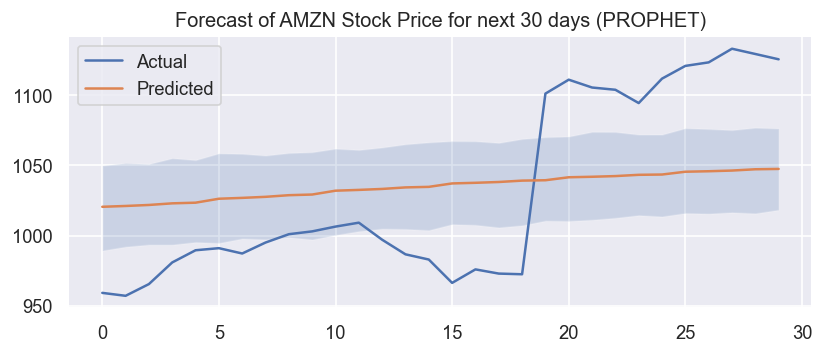

In [19]:
"""
plt.clf()
amazon_cl_train = amazon_cl.drop(amazon_cl.index[-30:])
rmse_prophet = []
mape_prophet = []
date_list = amazon_cl['ds'].tail(30).tolist()
# define the period for which we want a prediction
prophet_pred = []
for i in range(0, 30):
    model_hold_out = Prophet()
    model_hold_out.fit(amazon_cl_train)
    future_hold_out = list()
    date = date_list[i]
    future_hold_out.append([date])
    future_hold_out = pd.DataFrame(future_hold_out)
    future_hold_out.columns = ['ds']
    # use the model to make a forecast
    forecast_hold_out = model_hold_out.predict(future_hold_out)
    y_pred = forecast_hold_out['yhat'].values[0]
    print (y_pred)
    prophet_pred.append(y_pred)
    print (amazon_cl.iloc[amazon_cl_train.shape[0]])
    amazon_cl_train = amazon_cl_train.append(amazon_cl.iloc[amazon_cl_train.shape[0]])
    print (amazon_cl_train.shape[0])
"""
def prophet_model_eval(df, company_name):
    df_prophet = df.copy()
    df_prophet.reset_index(inplace=True)
    df_prophet = df_prophet.rename(columns = {'index':'ds','Close':'y'})
    prophet_train = df_prophet.drop(df_prophet.index[-30:])
    date_list = df_prophet['ds'].tail(30).tolist()
    model_hold_out = Prophet()
    model_hold_out.fit(prophet_train)
    future_hold_out = list()

# define the period for which we want a prediction
    for i in range(0, 30):
        date = date_list[i]
        future_hold_out.append([date])
    future_hold_out = pd.DataFrame(future_hold_out)
    future_hold_out.columns = ['ds']

# use the model to make a forecast
    forecast_hold_out = model_hold_out.predict(future_hold_out)
    print (forecast_hold_out)
    y_pred = forecast_hold_out['yhat'].values
    y_true = df_prophet['y'][-30:].values
    mse = mean_squared_error(y_true,y_pred)
    prophet_rmse = np.sqrt(mse)
    prophet_mape = np.mean(np.abs(y_true - y_pred)/np.abs(y_true))
    prophet_rmse_list = ((np.square(np.subtract(y_true,y_pred))))
    prophet_mape_list = (np.abs(y_true - y_pred)/np.abs(y_true))

# plot expected vs actual
    plt.plot(forecast_hold_out.index, y_true, label='Actual')
    plt.plot(forecast_hold_out.index, y_pred, label='Predicted')
    plt.fill_between(forecast_hold_out.index, forecast_hold_out['yhat_lower'].values, forecast_hold_out['yhat_upper'].values, alpha = 0.2 )
    plt.title('Forecast of ' + company_name + ' Stock Price for next 30 days (PROPHET)')
    plt.legend()
    plt.show()
    
    return (prophet_mape_list, prophet_rmse, prophet_mape)

prophet_model = prophet_model_eval(amazon_cl, 'AMZN')

{'AAN':               Open    High     Low   Close     Volume  Daily_Returns
 2006-01-03  13.900  14.276  13.617  14.187   462513.0       0.029237
 2006-01-04  14.196  14.206  13.900  13.998   327965.0      -0.013322
 2006-01-05  13.968  13.978  13.784  13.803   231487.0      -0.013931
 2006-01-06  13.940  14.058  13.705  14.058   325213.0       0.018474
 2006-01-09  14.078  14.412  14.038  14.325   780383.0       0.018993
 ...            ...     ...     ...     ...        ...            ...
 2017-11-06  36.280  36.570  35.570  35.590  1029506.0      -0.023058
 2017-11-07  35.720  35.720  34.290  34.440  1149793.0      -0.032312
 2017-11-08  35.510  36.090  34.800  35.990  1805497.0       0.045006
 2017-11-09  35.680  35.860  35.230  35.620   979951.0      -0.010281
 2017-11-10  37.600  38.060  36.260  36.590  1214968.0       0.027232
 
 [2987 rows x 6 columns],
 'ANF':               Open    High      Low   Close     Volume  Daily_Returns
 2006-01-03  54.419  54.938  53.6180  54.186  3

## MAPE plot <a class="anchor" id="MAPE"></a>

Text(0.5, 1.0, 'PE Density Plot')

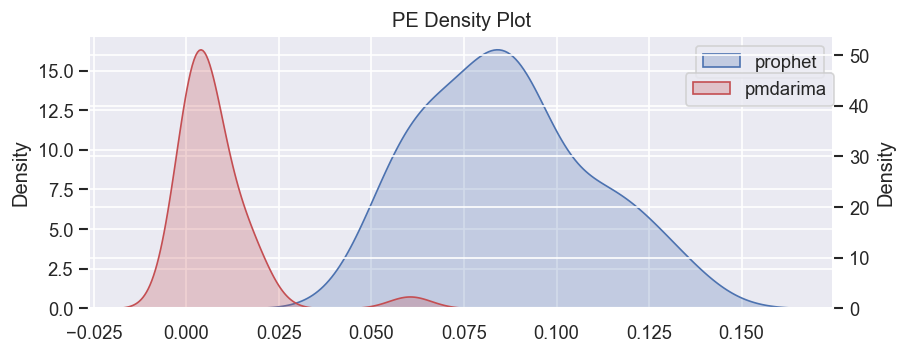

In [460]:
fig, ax = plt.subplots()
sns.kdeplot(prophet_model[0], fill = True, ax = ax, label = 'prophet')
plt.legend()
ax2 = ax.twinx()
sns.kdeplot(pmdarima_model[0], fill = True, ax = ax2,color='r',label = 'pmdarima')
plt.legend( bbox_to_anchor = (1.05,1), borderaxespad=2)
plt.title('PE Density Plot')

## Summary of MAPE and RMSE across all the Consumer Companies <a class="anchor" id="sum"></a>

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4811.019, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4812.026, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4813.896, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4813.891, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4811.010, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.056 seconds


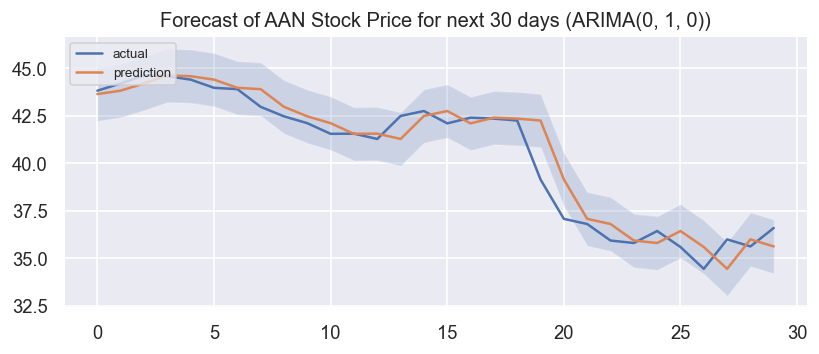

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -35.5347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6294.27   0.000249684       139.608      0.1907     0.01907      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6307.5   0.000597694       445.337     0.04048      0.5583      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       6310.31   0.000248123       172.328   2.215e-06       0.001      314  LS failed, Hessian reset 
     299       6313.49    0.00166306       336.162           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       6313.78   0.000348227       179.214    4.09e-06       0.001      477  LS failed, Hessian reset 
     378       6314.69   0.000474691       247.157   5.668e-06       0.001      575  LS failed, Hessian rese

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  32.066862   27.774421   36.260652    32.066862    32.066862   
1  2017-10-03  32.071429   27.840052   36.177243    32.071429    32.071429   
2  2017-10-04  32.075996   27.785264   36.104157    32.075996    32.075996   
3  2017-10-05  32.080563   27.132410   35.797688    32.080563    32.080563   
4  2017-10-06  32.085130   27.596876   35.899370    32.085130    32.085130   
5  2017-10-09  32.098832   27.184538   35.704566    32.098832    32.098832   
6  2017-10-10  32.103399   27.036910   35.363690    32.103399    32.103399   
7  2017-10-11  32.107966   27.065263   35.650210    32.107966    32.107966   
8  2017-10-12  32.112533   27.070857   35.737028    32.112533    32.112533   
9  2017-10-13  32.117100   27.064746   35.723392    32.117100    32.117100   
10 2017-10-16  32.130801   26.944993   35.750117    32.130801    32.130801   
11 2017-10-17  32.135369   27.029649   35.606440    32.135369   

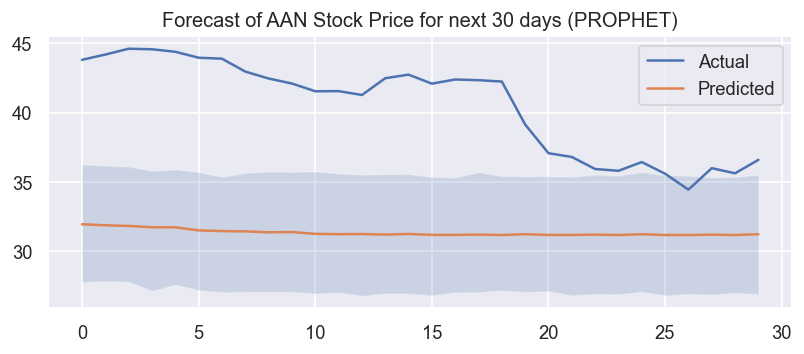

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8608.272, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8604.313, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8606.272, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8606.271, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8602.811, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.554 seconds


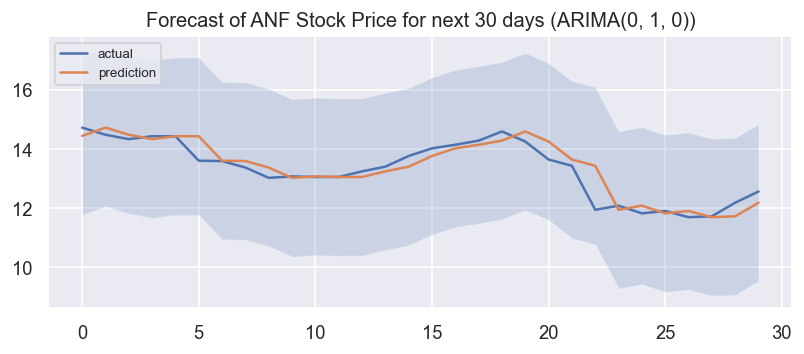

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -42.5897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5261.97     0.0830623        418.77           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5461.99     0.0580832       1585.05     0.09602           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5622.02     0.0263736       468.951      0.9952      0.9952      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5683.15     0.0305732        386.28       2.075      0.2075      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5723.91    0.00469089       435.322           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  11.922694    3.974317   15.436505    11.922694    11.922694   
1  2017-10-03  11.908728    4.286854   15.033430    11.908728    11.908728   
2  2017-10-04  11.894763    4.274113   15.616376    11.894763    11.894763   
3  2017-10-05  11.880797    3.964707   15.260228    11.880797    11.880797   
4  2017-10-06  11.866831    3.769061   15.394779    11.866831    11.866831   
5  2017-10-09  11.824934    3.849754   15.004327    11.824934    11.824934   
6  2017-10-10  11.810968    4.235672   15.184325    11.810968    11.810968   
7  2017-10-11  11.797002    3.950974   15.362283    11.797002    11.797002   
8  2017-10-12  11.783036    3.740482   15.658842    11.783036    11.783036   
9  2017-10-13  11.769071    3.942192   15.348393    11.769071    11.769071   
10 2017-10-16  11.727173    4.221525   15.653293    11.727173    11.727173   
11 2017-10-17  11.713207    4.256551   15.562748    11.713207   

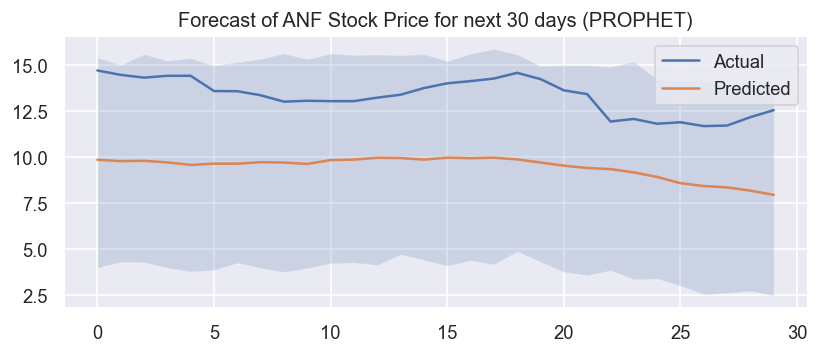

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11648.937, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11646.217, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11648.214, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11648.213, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11644.575, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.784 seconds


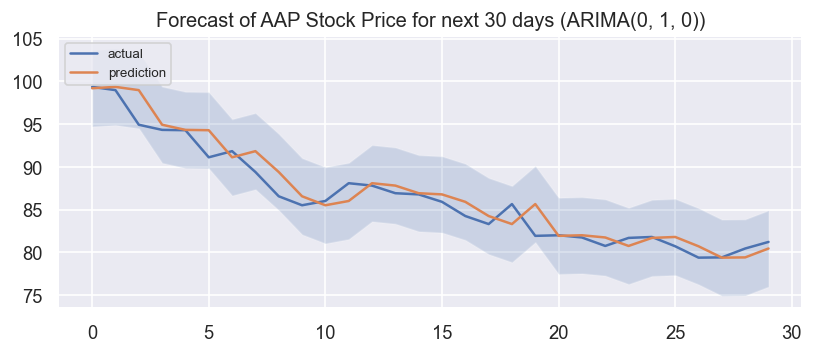

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -49.5422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7273.98     0.0255973       952.875       4.452      0.4452      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7402.14    0.00673956       323.792           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7438.03    0.00487324       324.436      0.1758           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7469.45     0.0167236       468.092      0.6778      0.6778      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        7492.8     0.0171366       468.037           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  130.949520  116.042267  137.434699   130.949520   130.949520   
1  2017-10-03  130.902214  115.455642  138.842127   130.902214   130.902214   
2  2017-10-04  130.854907  115.806327  138.988078   130.854907   130.854907   
3  2017-10-05  130.807600  115.297696  138.923504   130.807600   130.807600   
4  2017-10-06  130.760293  115.731793  138.385116   130.760293   130.760293   
5  2017-10-09  130.618372  115.303211  138.883217   130.618372   130.618372   
6  2017-10-10  130.571065  115.849275  138.257589   130.571065   130.571065   
7  2017-10-11  130.523758  116.129375  139.636159   130.523758   130.523758   
8  2017-10-12  130.476451  116.794367  139.626043   130.476451   130.476451   
9  2017-10-13  130.429145  115.376148  138.776667   130.429145   130.429145   
10 2017-10-16  130.287224  117.042372  139.989227   130.287224   130.287224   
11 2017-10-17  130.239917  116.874861  140.775205   

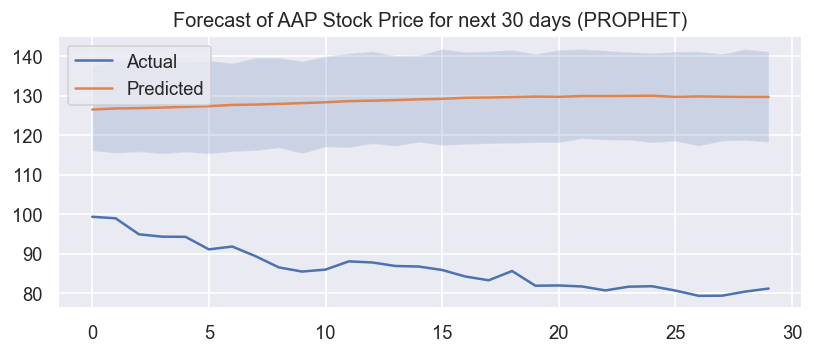

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5020.607, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5022.099, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5020.149, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5020.362, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5020.746, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5019.848, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5021.848, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5021.848, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5023.847, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5018.506, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5018.844, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5020.506, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5020.506, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5019.291, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]          

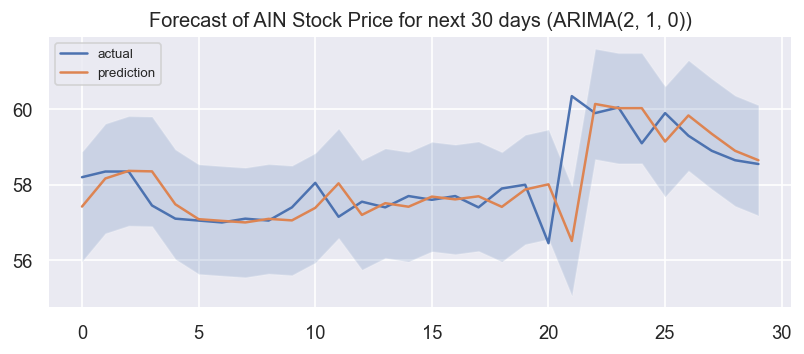

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -158.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6831.33      0.210384       2586.12           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7166.56     0.0429492        2657.8      0.2417           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7349.02     0.0775996       3046.87           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7387.52    0.00449042       605.691           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7412.91     0.0186787       526.774      0.2151       0.606      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  50.522863   47.231641   52.652643    50.522863    50.522863   
1  2017-10-03  50.544144   47.000109   52.545923    50.544144    50.544144   
2  2017-10-04  50.565425   46.864106   52.349426    50.565425    50.565425   
3  2017-10-05  50.586707   47.122970   52.517749    50.586707    50.586707   
4  2017-10-06  50.607988   46.637492   52.560924    50.607988    50.607988   
5  2017-10-09  50.671833   46.535805   52.200081    50.671833    50.671833   
6  2017-10-10  50.693114   46.607727   52.233912    50.693114    50.693114   
7  2017-10-11  50.714395   46.801102   52.345031    50.714395    50.714395   
8  2017-10-12  50.735677   46.632626   52.393614    50.735677    50.735677   
9  2017-10-13  50.756958   46.731679   52.385534    50.756958    50.756958   
10 2017-10-16  50.820803   46.754851   52.234448    50.820803    50.820803   
11 2017-10-17  50.842084   46.900069   52.462903    50.842084   

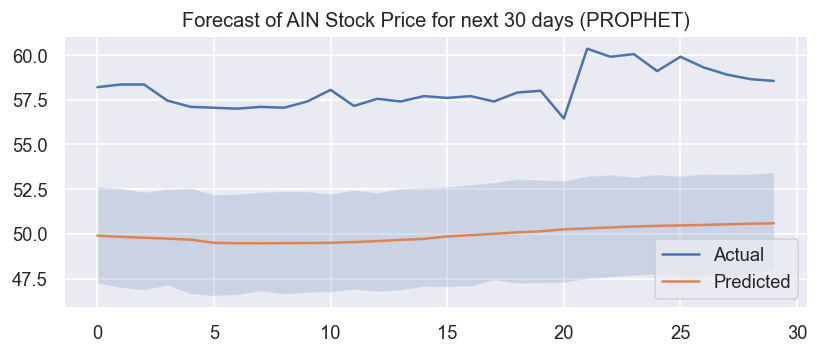

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19225.688, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19222.372, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19223.808, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19223.794, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19227.606, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.702 seconds


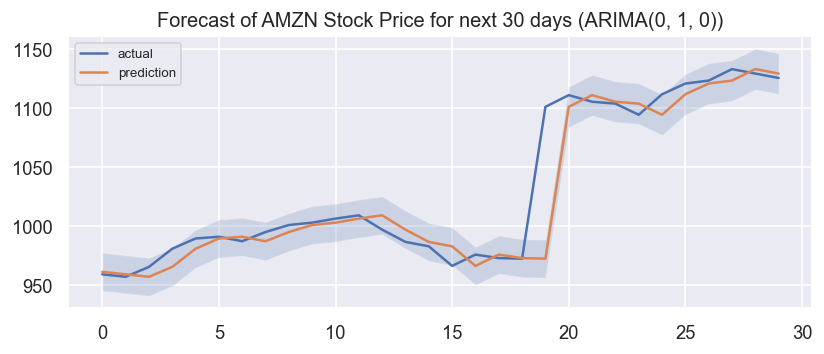

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -86.8346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9031.12      0.261814       9762.89           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9248.65     0.0478723       3335.78           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9399.91    0.00545629       1709.65           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9419.78    0.00027755       278.375           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        9444.5     0.0242538       2089.25           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2017-10-02  1014.739275   989.049626  1050.724537  1014.739275   
1  2017-10-03  1015.401637   991.416851  1050.321431  1015.401637   
2  2017-10-04  1016.063999   991.179770  1054.466167  1016.063999   
3  2017-10-05  1016.726361   993.555709  1051.769601  1016.726361   
4  2017-10-06  1017.388723   993.965469  1054.366118  1017.388723   
5  2017-10-09  1019.375809   997.209731  1056.164058  1019.375809   
6  2017-10-10  1020.038171   996.835097  1056.464832  1020.038171   
7  2017-10-11  1020.700533   998.452867  1058.423722  1020.700533   
8  2017-10-12  1021.362895   997.345407  1059.169282  1021.362895   
9  2017-10-13  1022.025257  1000.312490  1058.913291  1022.025257   
10 2017-10-16  1024.012343  1001.090402  1064.086392  1024.012343   
11 2017-10-17  1024.674705  1003.063461  1061.874458  1024.674705   
12 2017-10-18  1025.337067  1001.455137  1063.549532  1025.337067   
13 2017-10-19  1025.999429  1003.2

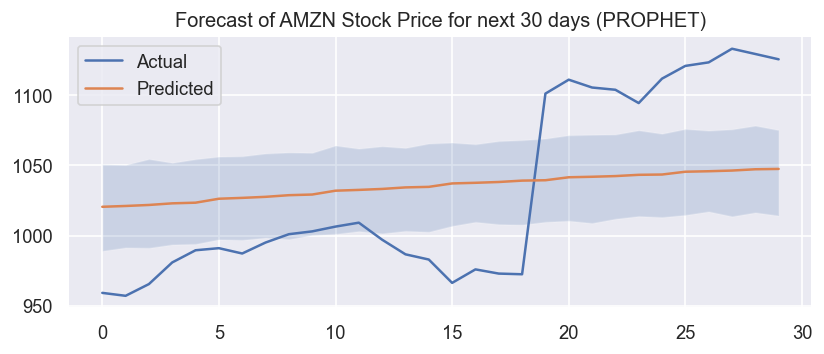

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3616.537, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3614.478, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3615.394, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3615.382, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3612.480, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.853 seconds


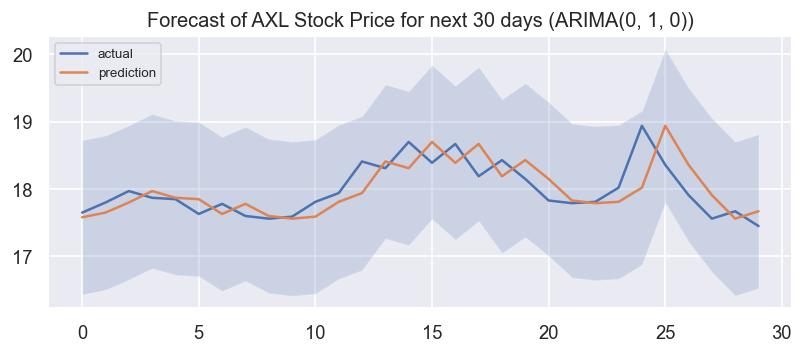

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -85.2717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5138.86     0.0206458       572.032           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5498.81     0.0187498       1179.75      0.1653           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5578.73    0.00506941       163.314      0.8312      0.8312      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5648.57    0.00597397       542.802      0.1316      0.7581      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5659.89     0.0036933       90.5137      0.9875      0.9875      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  15.700202   11.697127   16.991098    15.700202    15.700202   
1  2017-10-03  15.693531   11.869727   17.242305    15.693531    15.693531   
2  2017-10-04  15.686860   11.756116   17.274444    15.686860    15.686860   
3  2017-10-05  15.680189   11.779285   17.239527    15.680189    15.680189   
4  2017-10-06  15.673518   11.724748   17.338052    15.673518    15.673518   
5  2017-10-09  15.653505   11.518608   16.984904    15.653505    15.653505   
6  2017-10-10  15.646834   11.455443   16.993503    15.646834    15.646834   
7  2017-10-11  15.640163   11.370318   16.661781    15.640163    15.640163   
8  2017-10-12  15.633492   11.322453   17.205281    15.633492    15.633492   
9  2017-10-13  15.626821   11.598962   17.007178    15.626821    15.626821   
10 2017-10-16  15.606808   11.377261   16.799264    15.606808    15.606808   
11 2017-10-17  15.600137   11.311845   16.887322    15.600137   

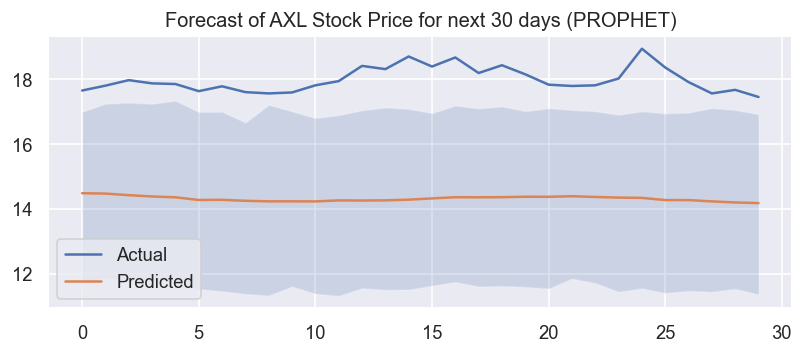

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8525.555, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8525.082, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8523.588, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8523.567, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8524.748, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8525.553, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8527.552, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8523.353, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8525.346, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8525.345, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8523.369, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8527.344, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.389 seconds


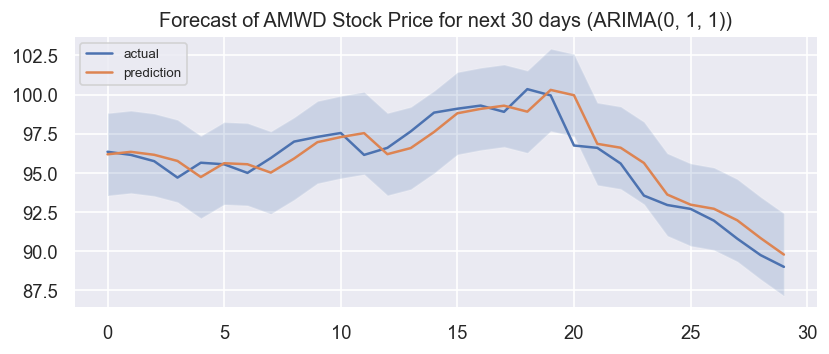

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -125.927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7573.69      0.173438       3924.39           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7822.58    0.00629151       817.826           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7940.67     0.0153858       1490.19      0.3893           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7973.88     0.0136876       928.107           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7993.38   0.000979311       216.724           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  93.071644   89.100311   98.143352    93.071644    93.071644   
1  2017-10-03  93.113371   89.277931   98.324616    93.113371    93.113371   
2  2017-10-04  93.155099   89.163748   98.392175    93.155099    93.155099   
3  2017-10-05  93.196826   89.200655   98.452628    93.196826    93.196826   
4  2017-10-06  93.238553   89.219194   98.784840    93.238553    93.238553   
5  2017-10-09  93.363735   89.263087   98.827370    93.363735    93.363735   
6  2017-10-10  93.405462   89.462087   98.648452    93.405462    93.405462   
7  2017-10-11  93.447189   89.396584   98.582641    93.447189    93.447189   
8  2017-10-12  93.488917   89.584888   98.887989    93.488917    93.488917   
9  2017-10-13  93.530644   89.416286   98.651194    93.530644    93.530644   
10 2017-10-16  93.655826   89.785118   98.713561    93.655826    93.655826   
11 2017-10-17  93.697553   90.039344   98.905945    93.697553   

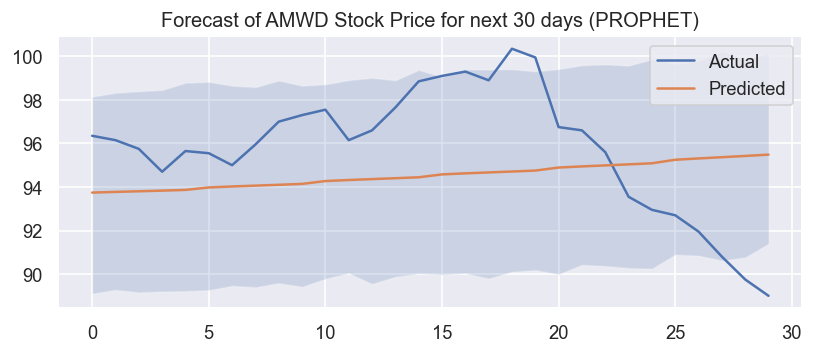

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9591.577, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9587.597, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9589.253, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9589.255, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9587.153, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.604 seconds


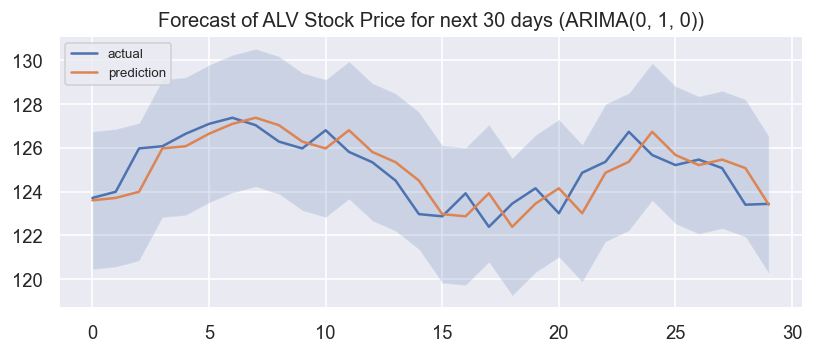

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -46.5675
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7321.9      0.222898       11244.4      0.2292           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7557.05    0.00677282       469.567           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7660.44     0.0218193       3152.53           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7701.16    0.00636511       326.632         0.9         0.9      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456        7718.4   0.000112716       341.592   2.096e-07       0.001      550  LS failed, Hessian reset 
     499        7721.8     0.0114513    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  105.934714   98.493289  110.683590   105.934714   105.934714   
1  2017-10-03  105.931933   98.636968  110.546800   105.931933   105.931933   
2  2017-10-04  105.929151   98.375410  110.431433   105.929151   105.929151   
3  2017-10-05  105.926370   98.935728  111.261851   105.926370   105.926370   
4  2017-10-06  105.923589   98.258063  110.212031   105.923589   105.923589   
5  2017-10-09  105.915244   98.149098  110.138730   105.915244   105.915244   
6  2017-10-10  105.912463   97.768749  110.107640   105.912463   105.912463   
7  2017-10-11  105.909681   98.314748  110.645542   105.909681   105.909681   
8  2017-10-12  105.906900   98.189507  110.526079   105.906900   105.906900   
9  2017-10-13  105.904118   97.553079  109.809805   105.904118   105.904118   
10 2017-10-16  105.895774   97.966488  110.550541   105.895774   105.895774   
11 2017-10-17  105.892992   98.297471  110.652958   

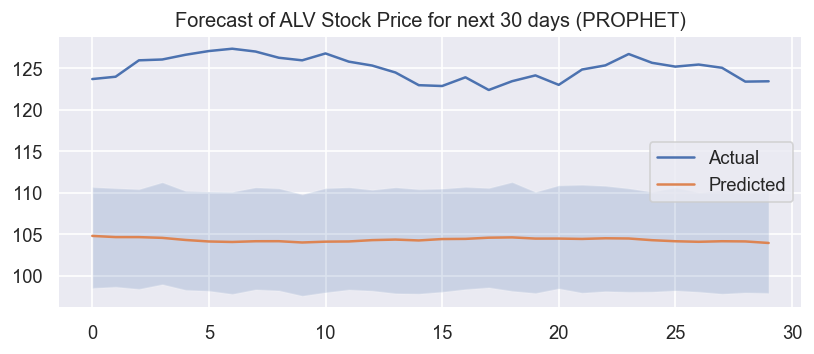

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6059.404, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6056.381, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6058.210, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6058.204, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6054.865, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.999 seconds


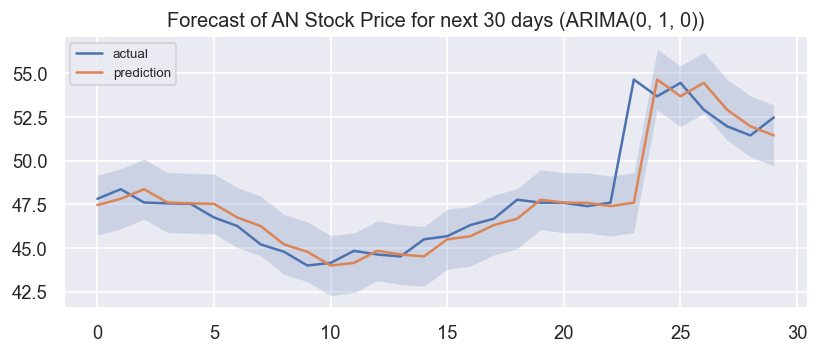

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -39.5111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7575.75     0.0262984       1972.15           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7730.18     0.0994784       936.857           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7791.37     0.0162183       912.504           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7825.11    0.00497812        163.05           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7836.51     0.0018373       291.724      0.8251      0.8251      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  38.813184   35.712576   42.243944    38.813184    38.813184   
1  2017-10-03  38.786395   35.711365   42.142582    38.786395    38.786395   
2  2017-10-04  38.759606   35.432281   42.335938    38.759606    38.759606   
3  2017-10-05  38.732818   35.562584   42.118501    38.732818    38.732818   
4  2017-10-06  38.706029   35.425858   41.746800    38.706029    38.706029   
5  2017-10-09  38.625662   35.275928   41.732272    38.625662    38.625662   
6  2017-10-10  38.598873   35.464823   41.813315    38.598873    38.598873   
7  2017-10-11  38.572084   35.271487   41.954316    38.572084    38.572084   
8  2017-10-12  38.545296   35.211125   41.514455    38.545296    38.545296   
9  2017-10-13  38.518507   35.443116   41.764618    38.518507    38.518507   
10 2017-10-16  38.438140   35.029867   41.739207    38.438140    38.438140   
11 2017-10-17  38.411351   35.269462   41.655076    38.411351   

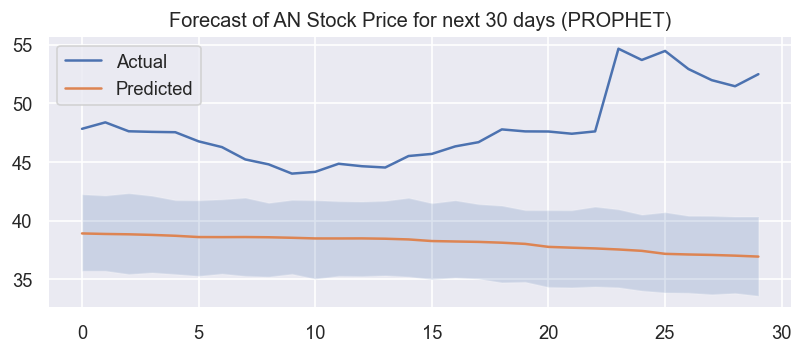

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18400.822, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18407.777, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18403.463, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18403.245, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18408.659, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18402.814, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18407.243, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18404.313, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18404.797, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18402.504, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=18402.550, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.085 seconds


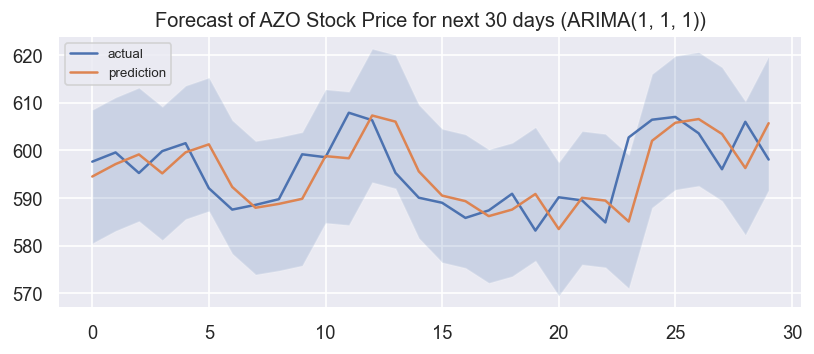

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.7945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7267.34     0.0736673       2530.46      0.9985      0.9985      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7484.39    0.00556238       2401.41       0.609       0.609      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7592.5     0.0162014       1458.58           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7629.83     0.0125054       761.809      0.3241      0.3241      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7661.83    0.00167043       256.896           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  667.655746  617.279274  706.756087   667.655746   667.655746   
1  2017-10-03  667.551898  616.675916  704.793125   667.551898   667.551898   
2  2017-10-04  667.448050  618.586036  706.316680   667.448050   667.448050   
3  2017-10-05  667.344201  620.387039  706.401847   667.344201   667.344201   
4  2017-10-06  667.240353  617.786966  702.770527   667.240353   667.240353   
5  2017-10-09  666.928808  615.690972  703.353715   666.928808   666.928808   
6  2017-10-10  666.824960  621.002324  703.914682   666.824960   666.824960   
7  2017-10-11  666.721111  619.465109  702.209081   666.721111   666.721111   
8  2017-10-12  666.617263  620.524933  703.076951   666.617263   666.617263   
9  2017-10-13  666.513415  617.963252  706.820357   666.513415   666.513415   
10 2017-10-16  666.201870  617.706331  705.153778   666.201870   666.201870   
11 2017-10-17  666.098021  618.568177  706.135606   

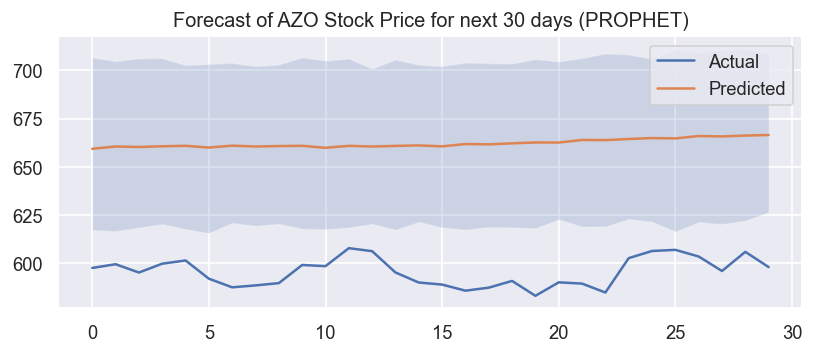

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1398.246, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1413.540, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1405.895, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1405.369, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1415.169, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1397.506, Time=1.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1405.737, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1409.428, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1400.061, Time=1.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1397.459, Time=1.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1405.561, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1401.541, Time=1.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1407.286, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1405.787, Time=2.08 sec
 ARIMA(1,1,2)(0,0,0)[0]          

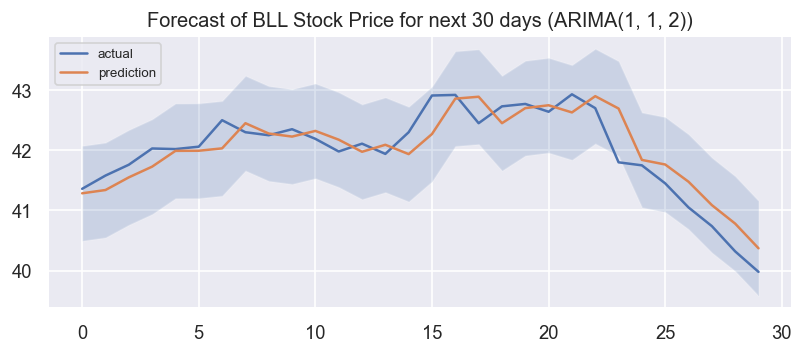

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.9158
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8904.13     0.0107567       1629.89           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9076.68    0.00441072       1280.23      0.3391      0.3391      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9131.38   0.000427598       461.478           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9172.66   0.000616455       535.045           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9186.54   0.000746558       520.204           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  40.123918   38.444989   41.104287    40.123918    40.123918   
1  2017-10-03  40.131974   38.323343   41.016473    40.131974    40.131974   
2  2017-10-04  40.140029   38.428871   41.067292    40.140029    40.140029   
3  2017-10-05  40.148085   38.458231   40.994271    40.148085    40.148085   
4  2017-10-06  40.156141   38.442558   41.112752    40.156141    40.156141   
5  2017-10-09  40.180309   38.336636   41.049605    40.180309    40.180309   
6  2017-10-10  40.188365   38.459185   41.103233    40.188365    40.188365   
7  2017-10-11  40.196421   38.399600   41.033609    40.196421    40.196421   
8  2017-10-12  40.204477   38.521402   41.035982    40.204477    40.204477   
9  2017-10-13  40.212533   38.517796   41.064464    40.212533    40.212533   
10 2017-10-16  40.236700   38.663811   41.226908    40.236700    40.236700   
11 2017-10-17  40.244756   38.684439   41.304055    40.244756   

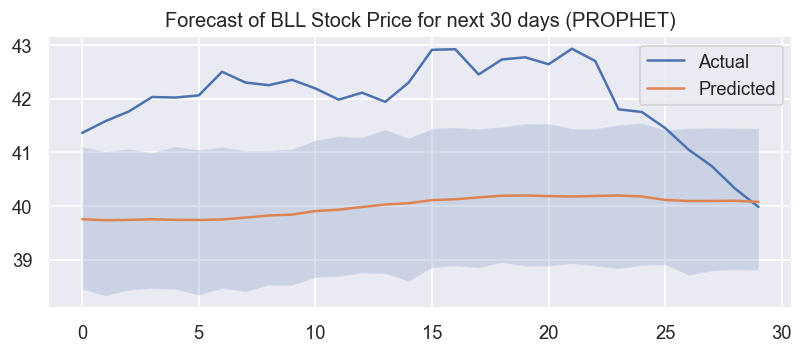

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7508.546, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7512.194, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7506.601, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7506.558, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7510.262, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7508.548, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7510.549, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7504.633, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7506.622, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7506.623, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7504.676, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7508.625, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.602 seconds


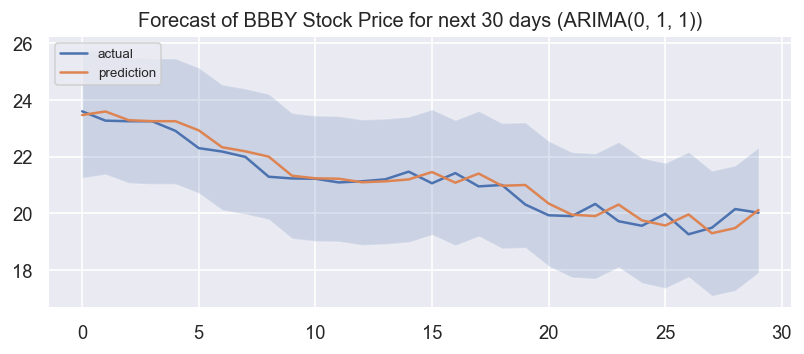

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -147.524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6925.77    0.00382378        630.33           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7038.27    0.00168395       508.318       0.274       0.274      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7068.1    0.00679547       483.931           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7101.54     0.0138546        726.05           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7138.36    0.00841228       624.032           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  26.412097   22.655452   30.472216    26.412097    26.412097   
1  2017-10-03  26.367161   22.411696   30.198141    26.367161    26.367161   
2  2017-10-04  26.322225   22.472494   30.360625    26.322225    26.322225   
3  2017-10-05  26.277289   22.467868   30.105966    26.277289    26.277289   
4  2017-10-06  26.232353   22.240742   30.060771    26.232353    26.232353   
5  2017-10-09  26.097545   21.824655   29.670148    26.097545    26.097545   
6  2017-10-10  26.052609   21.837506   29.999177    26.052609    26.052609   
7  2017-10-11  26.007673   21.788690   29.665509    26.007673    26.007673   
8  2017-10-12  25.962737   21.620452   29.915380    25.962737    25.962737   
9  2017-10-13  25.917801   21.604567   29.325386    25.917801    25.917801   
10 2017-10-16  25.782993   20.982787   29.113567    25.782993    25.782993   
11 2017-10-17  25.738057   21.364089   29.778726    25.738057   

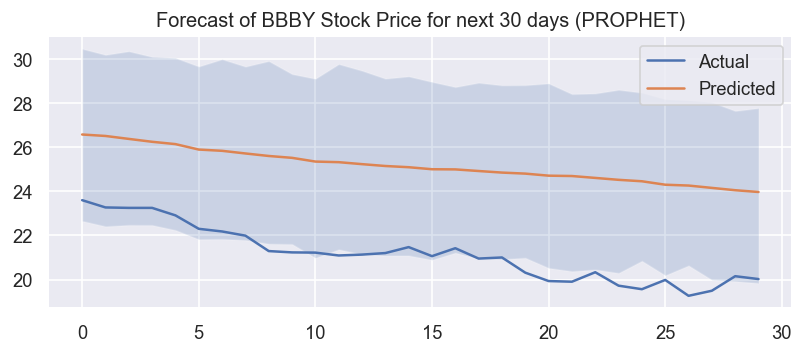

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6854.027, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6850.743, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6852.396, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6852.365, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6848.987, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.976 seconds


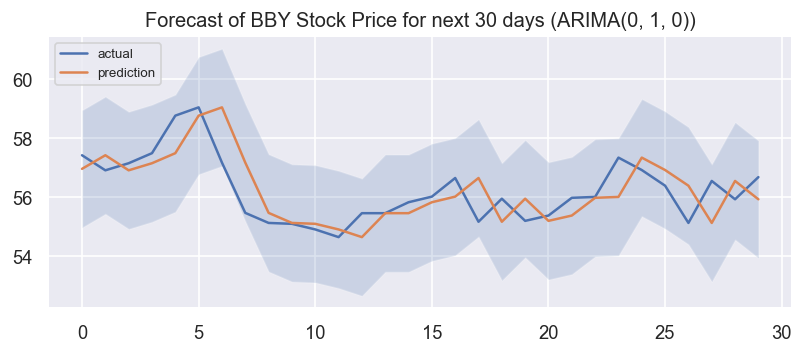

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2144.778, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2146.032, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2144.218, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2144.309, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2144.305, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2145.781, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2146.756, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2142.512, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2144.067, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2143.063, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2142.603, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2145.043, Time=0.34 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.105 seconds


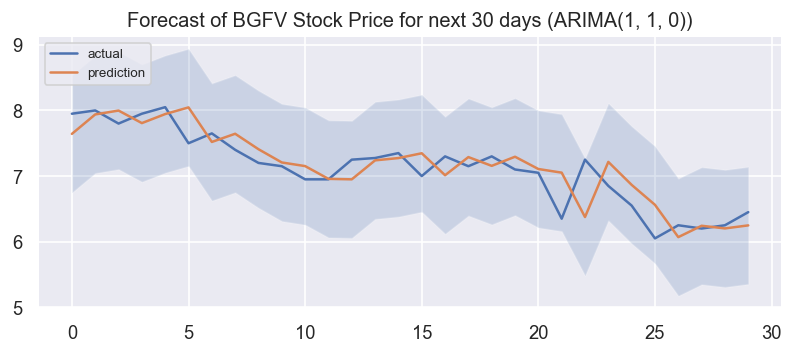

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.4615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4644.52     0.0112425       948.098      0.4495      0.4495      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4932.08     0.0130231       1780.96      0.1727      0.1727      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5043.38     0.0297001       350.085      0.9317      0.9317      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5087.64     0.0129582       362.145           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5112.5    0.00144883       418.289      0.7194     0.07194      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  13.331890   10.448455   14.632429    13.331890    13.331890   
1  2017-10-03  13.334242   10.431292   14.619294    13.334242    13.334242   
2  2017-10-04  13.336595   10.517665   14.621658    13.336595    13.336595   
3  2017-10-05  13.338947   10.387157   14.504939    13.338947    13.338947   
4  2017-10-06  13.341300   10.418468   14.646993    13.341300    13.341300   
5  2017-10-09  13.348357   10.438774   14.734449    13.348357    13.348357   
6  2017-10-10  13.350710   10.631026   14.584795    13.350710    13.350710   
7  2017-10-11  13.353062   10.679926   14.762822    13.353062    13.353062   
8  2017-10-12  13.355415   10.660715   14.739368    13.355415    13.355415   
9  2017-10-13  13.357767   10.522537   14.734238    13.357767    13.357767   
10 2017-10-16  13.364825   10.727449   14.800161    13.364825    13.364825   
11 2017-10-17  13.367177   10.677347   14.978063    13.367177   

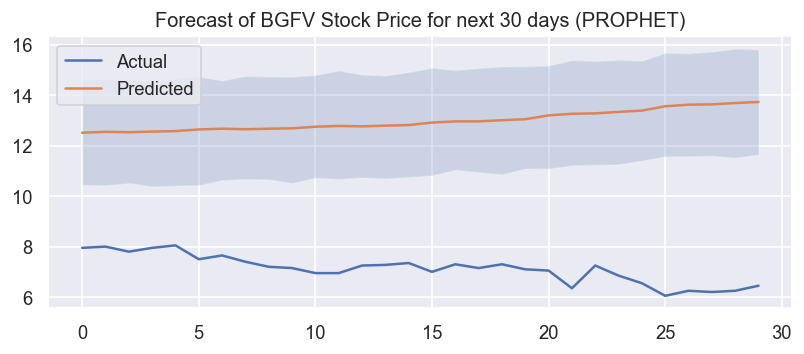

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19982.708, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19990.442, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19981.633, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19982.019, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19988.442, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19982.726, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19983.709, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19979.633, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19980.726, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19980.708, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19980.019, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19981.709, Time=0.29 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.171 seconds


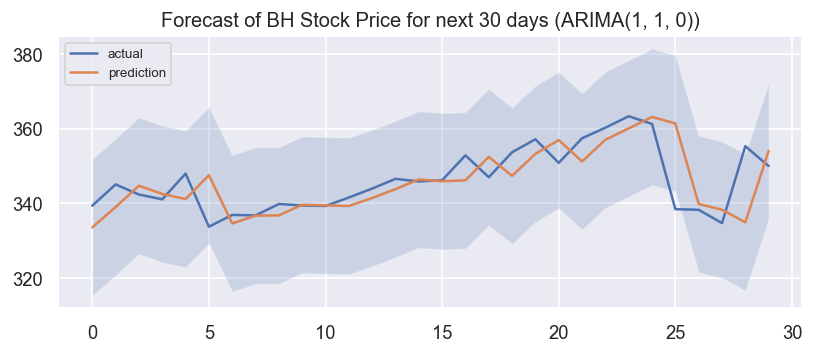

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -51.0865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6001.49       0.10974       2422.83      0.9342      0.9342      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6216.88     0.0266247       733.449           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6265.97    0.00358127       199.082      0.3856           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6293.14    0.00685252       207.167           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       6303.07   0.000198393       171.796    4.21e-07       0.001      604  LS failed, Hessian reset 
     497       6304.86   8.24904e-05    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  401.676977  354.422008  434.258850   401.676977   401.676977   
1  2017-10-03  401.695070  354.267341  434.241073   401.695070   401.695070   
2  2017-10-04  401.713163  354.687004  436.285902   401.713163   401.713163   
3  2017-10-05  401.731256  356.206836  433.420984   401.731256   401.731256   
4  2017-10-06  401.749349  355.197745  434.735131   401.749349   401.749349   
5  2017-10-09  401.803629  351.575443  435.231761   401.803629   401.803629   
6  2017-10-10  401.821722  354.060864  435.509729   401.821722   401.821722   
7  2017-10-11  401.839815  357.280003  435.828653   401.839815   401.839815   
8  2017-10-12  401.857908  355.459647  435.872369   401.857908   401.857908   
9  2017-10-13  401.876001  354.373091  437.523359   401.876001   401.876001   
10 2017-10-16  401.930281  355.346007  436.095924   401.930281   401.930281   
11 2017-10-17  401.948374  356.935452  435.278499   

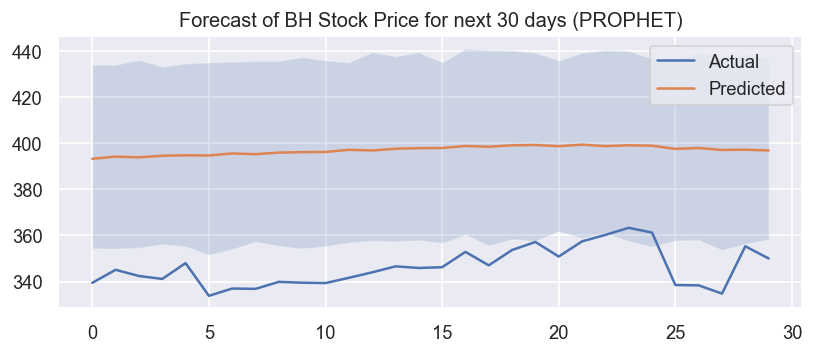

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4929.932, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4934.325, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4932.236, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4931.905, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4932.446, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4931.527, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4931.515, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4929.873, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4931.413, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4933.154, Time=1.76 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4928.017, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4930.037, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4929.663, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4929.560, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]          

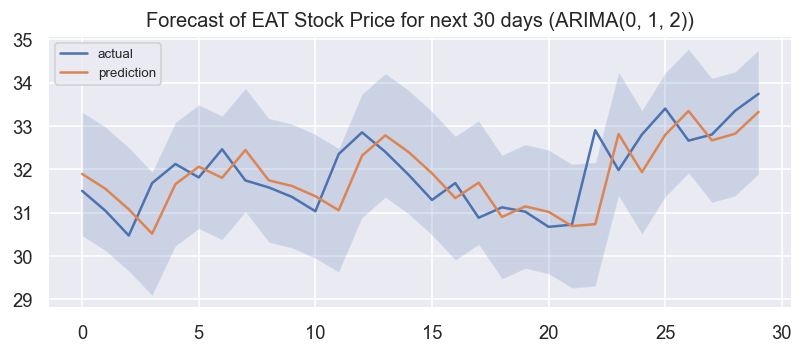

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -62.1343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7249.27     0.0642784       3519.95           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7378.65     0.0183635       539.371           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7442.74    0.00332247        235.89      0.2101      0.2101      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       7452.35   0.000101396       205.214   4.425e-07       0.001      486  LS failed, Hessian reset 
     399       7452.76    0.00261692       144.911           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       7458.36   0.000215742    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  38.074474   34.709779   41.217103    38.074474    38.074474   
1  2017-10-03  38.057870   34.617860   41.479903    38.057870    38.057870   
2  2017-10-04  38.041266   34.357998   41.131893    38.041266    38.041266   
3  2017-10-05  38.024661   34.456451   41.067626    38.024661    38.024661   
4  2017-10-06  38.008057   34.073354   41.053295    38.008057    38.008057   
5  2017-10-09  37.958244   34.379372   40.658520    37.958244    37.958244   
6  2017-10-10  37.941640   33.943769   40.696279    37.941640    37.941640   
7  2017-10-11  37.925035   34.002083   40.778385    37.925035    37.925035   
8  2017-10-12  37.908431   34.042369   40.635575    37.908431    37.908431   
9  2017-10-13  37.891826   33.986213   40.726068    37.891826    37.891826   
10 2017-10-16  37.842013   33.781962   40.242331    37.842013    37.842013   
11 2017-10-17  37.825409   33.406830   40.400315    37.825409   

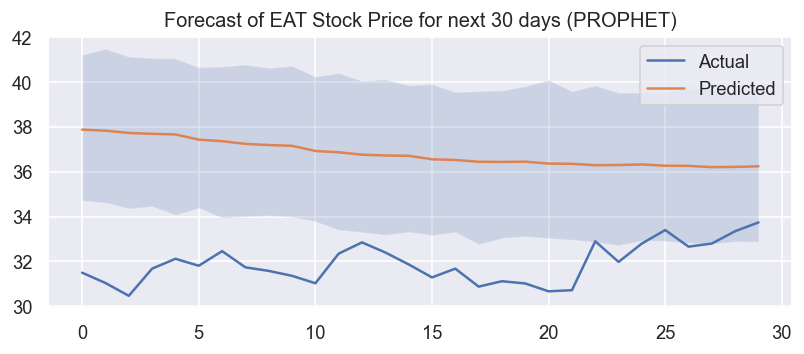

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6032.955, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6030.039, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6031.351, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6031.329, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6028.260, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.055 seconds


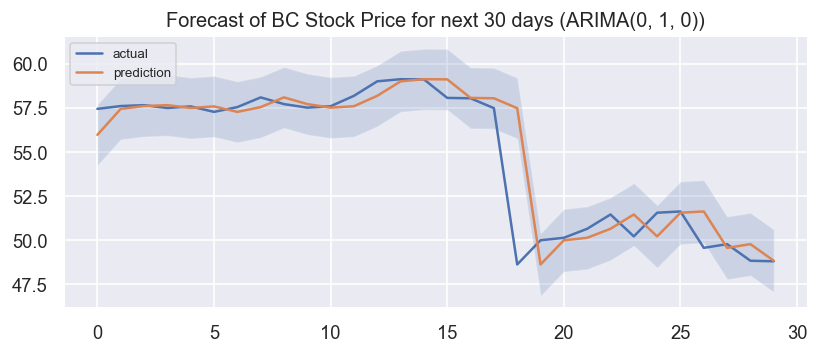

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -175.968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6945.32    0.00436785       1954.51      0.2587      0.2587      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7130.23     0.0840064       1647.23           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7195.58    0.00693814       544.019           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       7198.38   0.000198829        271.87   1.411e-06       0.001      393  LS failed, Hessian reset 
     399       7210.15   0.000124003       69.3556      0.4616      0.4616      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7218.39    0.00340178    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  55.942250   50.390986   57.980583    55.942250    55.942250   
1  2017-10-03  55.951866   50.075694   58.097275    55.951866    55.951866   
2  2017-10-04  55.961482   50.304876   58.207156    55.961482    55.961482   
3  2017-10-05  55.971098   50.417350   57.884883    55.971098    55.971098   
4  2017-10-06  55.980714   50.695958   58.004851    55.980714    55.980714   
5  2017-10-09  56.009563   50.187593   58.104949    56.009563    56.009563   
6  2017-10-10  56.019179   50.222138   58.269956    56.019179    56.019179   
7  2017-10-11  56.028795   50.297645   58.039812    56.028795    56.028795   
8  2017-10-12  56.038411   50.057188   57.943113    56.038411    56.038411   
9  2017-10-13  56.048027   50.351919   57.871853    56.048027    56.048027   
10 2017-10-16  56.076875   50.477839   58.436905    56.076875    56.076875   
11 2017-10-17  56.086491   50.111166   58.218790    56.086491   

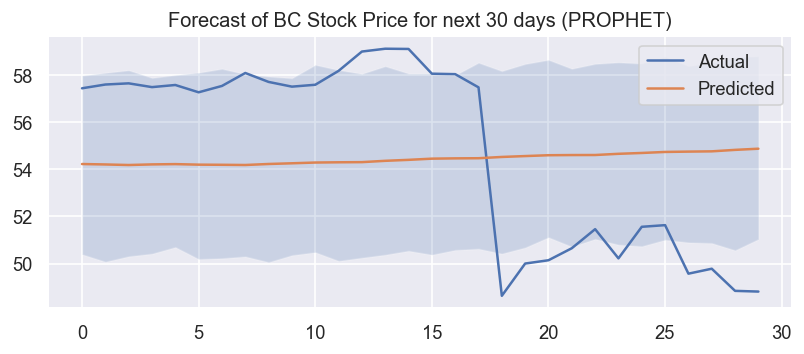

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3333.490, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3332.462, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3332.208, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3332.083, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3331.242, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.038 seconds


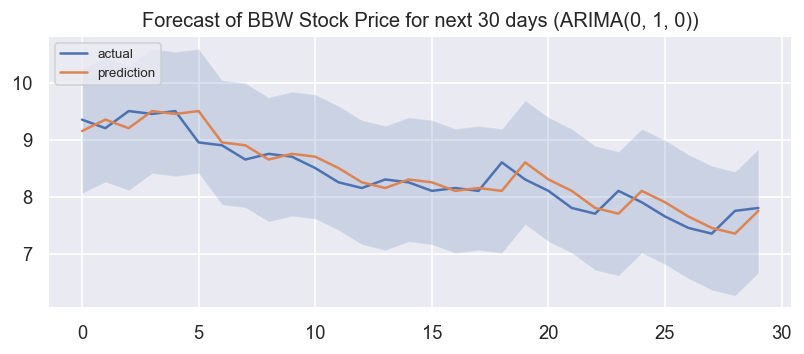

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -177.421
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6241.5       0.01981       1437.28      0.8686      0.8686      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6573.47    0.00895531       783.985           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6643.81     0.0877602       1282.67      0.9765      0.9765      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6682.44    0.00480379        169.38           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6689.89    0.00642884       187.235           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  8.767662    5.941955   10.003949     8.767662     8.767662   
1  2017-10-03  8.757392    5.816848   10.055813     8.757392     8.757392   
2  2017-10-04  8.747123    5.868837   10.038100     8.747123     8.747123   
3  2017-10-05  8.736854    5.780291    9.739818     8.736854     8.736854   
4  2017-10-06  8.726584    5.852718   10.223503     8.726584     8.726584   
5  2017-10-09  8.695776    5.846775    9.854810     8.695776     8.695776   
6  2017-10-10  8.685506    5.842524   10.203856     8.685506     8.685506   
7  2017-10-11  8.675237    5.903277   10.064826     8.675237     8.675237   
8  2017-10-12  8.664968    5.806972   10.115212     8.664968     8.664968   
9  2017-10-13  8.654698    5.779673   10.144152     8.654698     8.654698   
10 2017-10-16  8.623890    5.815807   10.201400     8.623890     8.623890   
11 2017-10-17  8.613620    5.927835   10.260817     8.613620     8.613620   

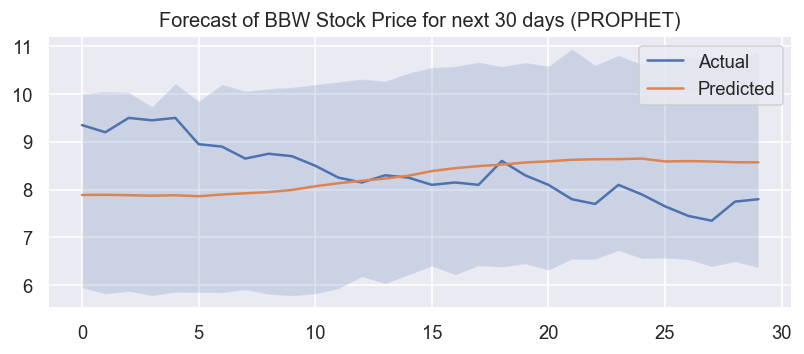

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6824.399, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6821.373, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6823.369, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6823.368, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6821.551, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.987 seconds


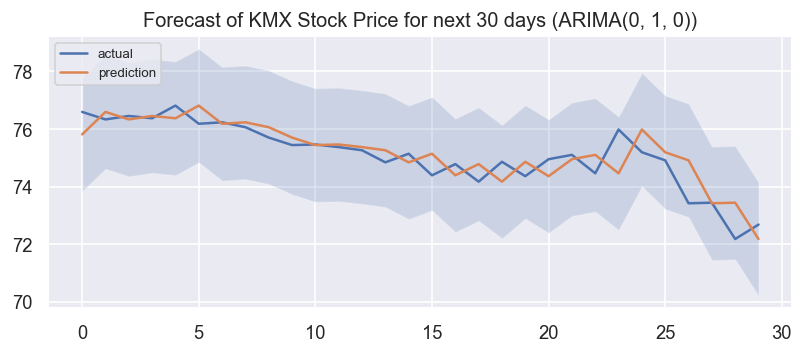

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -40.7431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6607.82     0.0108638       615.887           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6655.92   0.000488491       120.502           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       6674.68   0.000405261       218.839   2.948e-06       0.001      362  LS failed, Hessian reset 
     299       6677.99     0.0118873       494.647           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6689.45     0.0125849       229.413           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6701.74     0.0215464    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  60.029266   53.109221   63.932209    60.029266    60.029266   
1  2017-10-03  60.030027   52.788914   63.627581    60.030027    60.030027   
2  2017-10-04  60.030788   52.222111   63.775997    60.030788    60.030788   
3  2017-10-05  60.031549   52.895299   63.284817    60.031549    60.031549   
4  2017-10-06  60.032310   52.197974   63.627269    60.032310    60.032310   
5  2017-10-09  60.034594   52.388263   63.049441    60.034594    60.034594   
6  2017-10-10  60.035355   52.576753   63.266501    60.035355    60.035355   
7  2017-10-11  60.036116   52.308559   62.680446    60.036116    60.036116   
8  2017-10-12  60.036877   52.231739   63.405214    60.036877    60.036877   
9  2017-10-13  60.037638   52.221031   63.320834    60.037638    60.037638   
10 2017-10-16  60.039922   52.249224   63.572308    60.039922    60.039922   
11 2017-10-17  60.040683   52.601999   63.321899    60.040683   

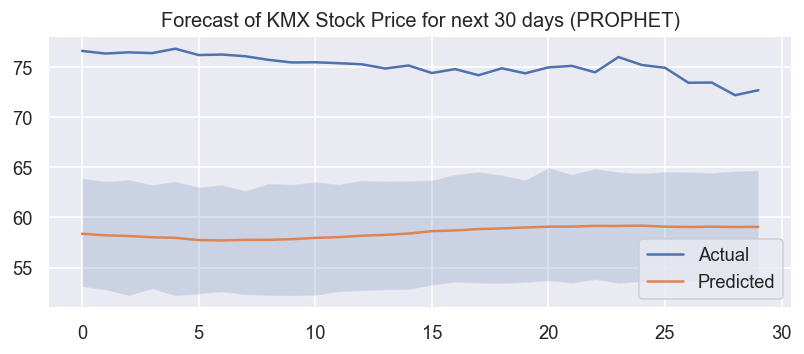

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5958.330, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5961.672, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5963.076, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5962.994, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5959.961, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5956.244, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5954.318, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5956.284, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5958.282, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5952.653, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5961.373, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5954.621, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5954.584, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5956.727, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]          

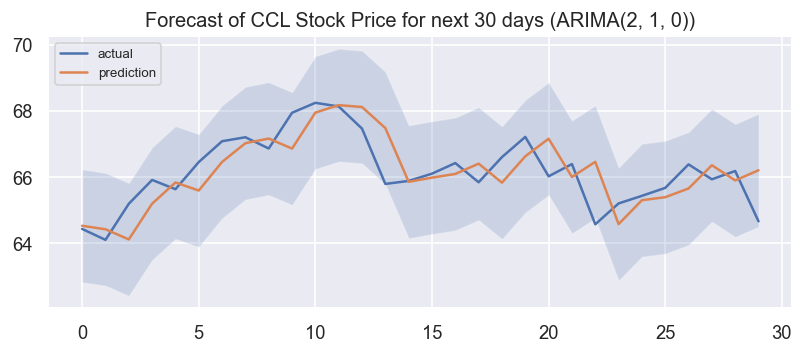

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -129.717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7264.97      0.241292       3345.88           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7364.15     0.0818884       750.159           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7410.58    0.00329951       217.052           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7435.78   0.000675191       207.736      0.8082      0.8082      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7452.38    0.00355234       125.004           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  61.875634   56.914144   64.666050    61.875634    61.875634   
1  2017-10-03  61.897337   57.030050   64.906175    61.897337    61.897337   
2  2017-10-04  61.919040   57.076173   64.827310    61.919040    61.919040   
3  2017-10-05  61.940743   57.201029   64.955641    61.940743    61.940743   
4  2017-10-06  61.962446   57.390046   64.694490    61.962446    61.962446   
5  2017-10-09  62.027555   56.996416   64.894357    62.027555    62.027555   
6  2017-10-10  62.049258   56.871392   64.880721    62.049258    62.049258   
7  2017-10-11  62.070961   56.904568   64.744619    62.070961    62.070961   
8  2017-10-12  62.092664   57.143156   64.920533    62.092664    62.092664   
9  2017-10-13  62.114367   57.060471   64.848655    62.114367    62.114367   
10 2017-10-16  62.179476   57.262228   65.018017    62.179476    62.179476   
11 2017-10-17  62.201179   57.335081   64.789359    62.201179   

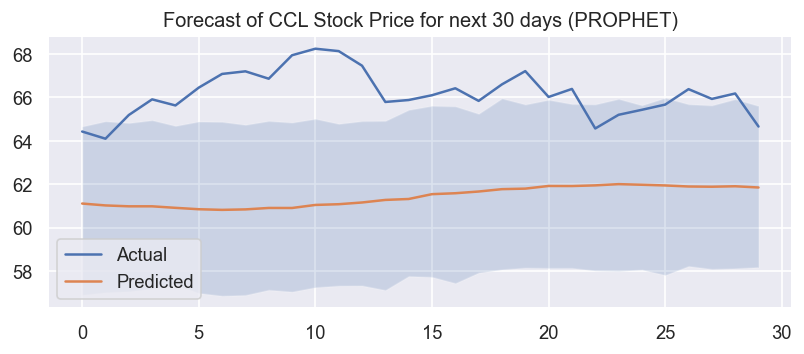

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5988.315, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5988.674, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5990.417, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5990.384, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5986.877, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.994 seconds


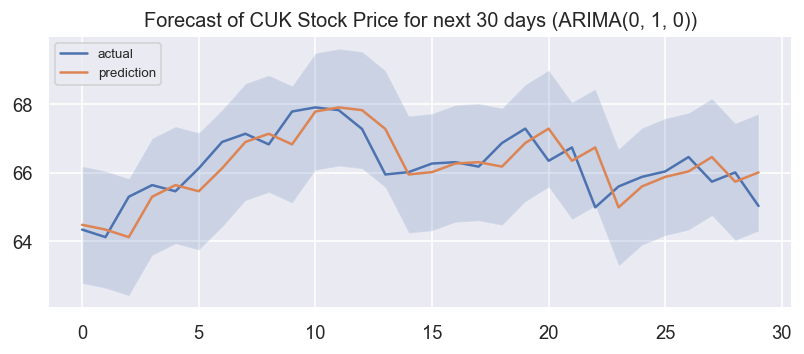

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -136.844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7017.07     0.0222674       1310.09           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7194.64     0.0165671       380.642           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7239.55    0.00271468       605.735           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7270.73    0.00595741       127.133           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7285.08    0.00665079       1550.09      0.6565      0.6565      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  61.775629   56.602987   64.795973    61.775629    61.775629   
1  2017-10-03  61.795555   56.445022   64.759847    61.795555    61.795555   
2  2017-10-04  61.815481   56.688489   64.550966    61.815481    61.815481   
3  2017-10-05  61.835407   56.672133   64.733378    61.835407    61.835407   
4  2017-10-06  61.855333   56.632685   64.545516    61.855333    61.855333   
5  2017-10-09  61.915111   56.387859   64.459266    61.915111    61.915111   
6  2017-10-10  61.935037   56.345049   64.684439    61.935037    61.935037   
7  2017-10-11  61.954963   56.269679   64.284418    61.954963    61.954963   
8  2017-10-12  61.974889   56.197481   64.581810    61.974889    61.974889   
9  2017-10-13  61.994815   56.255877   64.391799    61.994815    61.994815   
10 2017-10-16  62.054593   56.369186   64.698605    62.054593    62.054593   
11 2017-10-17  62.074519   56.472838   64.424640    62.074519   

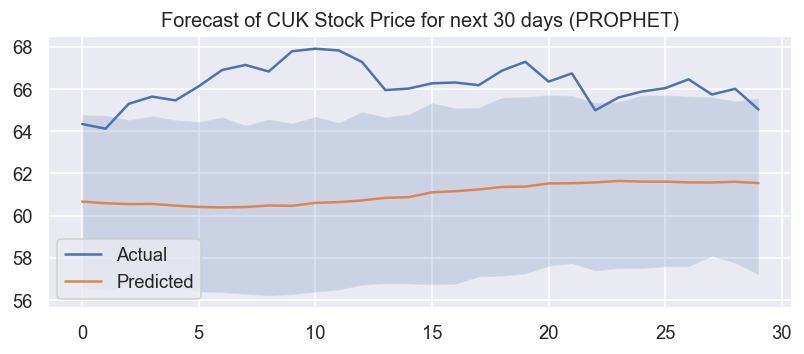

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=218.024, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=219.618, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=218.455, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=218.297, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=219.946, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=219.765, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=218.130, Time=0.91 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=218.477, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=218.726, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=219.610, Time=1.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=218.726, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.264 seconds


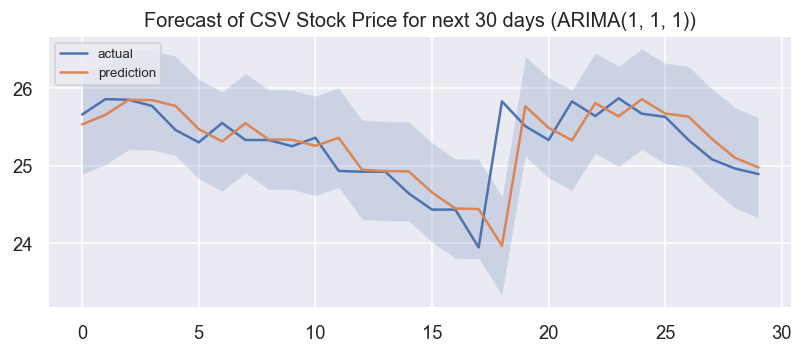

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -51.633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7269.27      0.046296       8108.14      0.9362      0.9362      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7577.97     0.0638116       2663.75           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7725.15    0.00163479       328.585           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7747.51    0.00122116       481.796      0.4969      0.4969      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7760.33   0.000168756       262.153      0.6427      0.6427      564   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  26.303252   24.250360   26.854711    26.303252    26.303252   
1  2017-10-03  26.307823   24.245996   27.077711    26.307823    26.307823   
2  2017-10-04  26.312395   24.307392   26.806947    26.312395    26.312395   
3  2017-10-05  26.316966   24.361867   26.975242    26.316966    26.316966   
4  2017-10-06  26.321537   24.340257   26.989480    26.321537    26.321537   
5  2017-10-09  26.335250   24.257513   27.017745    26.335250    26.335250   
6  2017-10-10  26.339821   24.393553   26.963511    26.339821    26.339821   
7  2017-10-11  26.344392   24.386136   27.133021    26.344392    26.344392   
8  2017-10-12  26.348964   24.413278   27.182477    26.348964    26.348964   
9  2017-10-13  26.353535   24.412474   27.104645    26.353535    26.353535   
10 2017-10-16  26.367248   24.514266   27.163900    26.367248    26.367248   
11 2017-10-17  26.371819   24.578606   27.298506    26.371819   

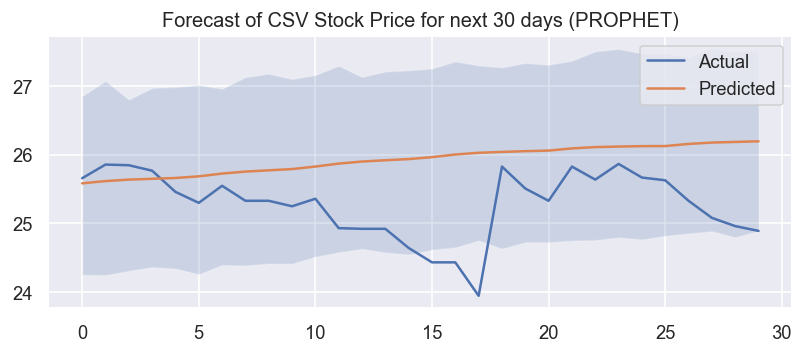

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2387.151, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2387.795, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2387.744, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2387.684, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2389.001, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.169 seconds


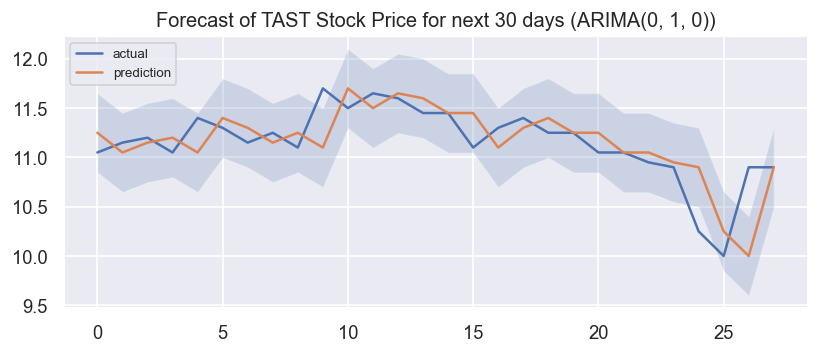

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -50.3992
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6681.95     0.0109399       481.611           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6917.93     0.0092095       1197.63           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7024.45    0.00232085       770.159      0.3776      0.3776      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7091.29    0.00146331       270.756           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7137.81    0.00589902       1159.35           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  13.367834   12.438668   13.985047    13.367834    13.367834   
1  2017-10-03  13.369252   12.499228   14.033042    13.369252    13.369252   
2  2017-10-04  13.370670   12.544624   14.035946    13.370670    13.370670   
3  2017-10-05  13.372088   12.459456   14.022054    13.372088    13.372088   
4  2017-10-06  13.373506   12.509633   14.011559    13.373506    13.373506   
5  2017-10-09  13.377759   12.477395   14.011077    13.377759    13.377759   
6  2017-10-10  13.379177   12.515861   14.088001    13.379177    13.379177   
7  2017-10-11  13.380594   12.445444   14.033125    13.380594    13.380594   
8  2017-10-12  13.382012   12.472451   14.000458    13.382012    13.382012   
9  2017-10-13  13.383430   12.453826   13.991430    13.383430    13.383430   
10 2017-10-16  13.387683   12.474038   14.093175    13.387683    13.387683   
11 2017-10-17  13.389101   12.450937   14.020107    13.389101   

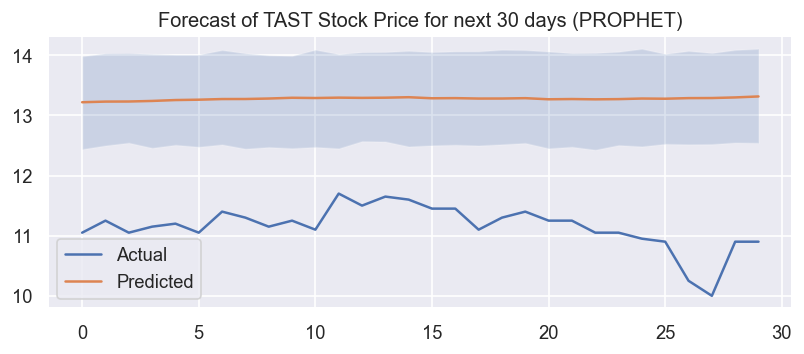

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10135.937, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10140.976, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10135.192, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10135.352, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10141.183, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10136.831, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10137.831, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10135.638, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.891 seconds


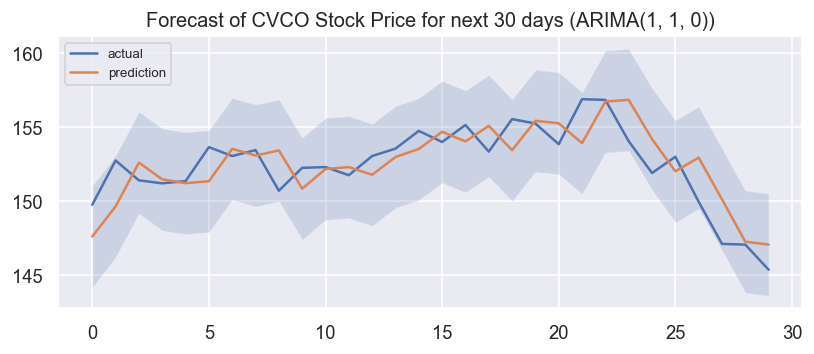

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -117.499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8276.62   0.000782364        744.39      0.8657      0.8657      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8496.28   0.000395232       387.374           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8642.74    0.00960226        660.29      0.3906           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8668.14    0.00659225       297.776      0.8699     0.08699      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8687.19   0.000910576       222.514           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  126.348220  119.820691  130.872790   126.348220   126.348220   
1  2017-10-03  126.417118  119.840284  131.146567   126.417118   126.417118   
2  2017-10-04  126.486017  120.053409  131.343594   126.486017   126.486017   
3  2017-10-05  126.554915  120.028928  130.520183   126.554915   126.554915   
4  2017-10-06  126.623814  120.427966  131.051965   126.623814   126.623814   
5  2017-10-09  126.830509  120.240819  130.984400   126.830509   126.830509   
6  2017-10-10  126.899407  120.071961  131.020972   126.899407   126.899407   
7  2017-10-11  126.968306  119.860924  131.298908   126.968306   126.968306   
8  2017-10-12  127.037204  120.316532  130.939161   127.037204   127.037204   
9  2017-10-13  127.106103  120.319602  131.358624   127.106103   127.106103   
10 2017-10-16  127.312798  120.558013  131.247614   127.312798   127.312798   
11 2017-10-17  127.381696  120.758309  131.450726   

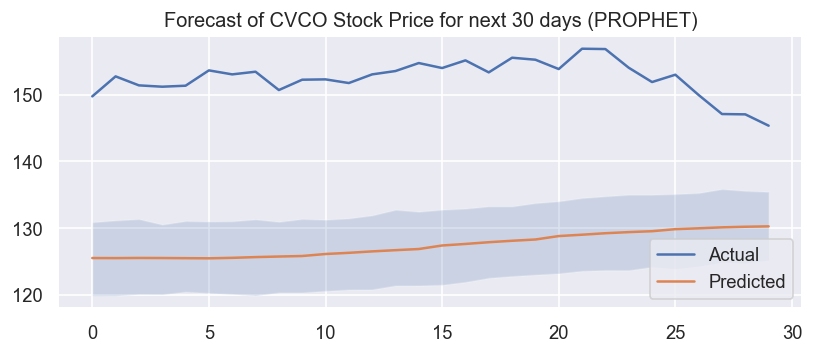

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3212.447, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3216.215, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3210.973, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3211.196, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3218.072, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3212.286, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3214.270, Time=1.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3212.456, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.307 seconds


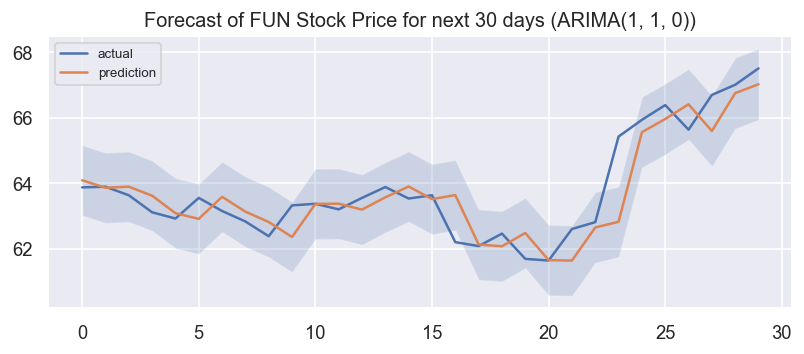

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -84.8447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9247.82     0.0115754       2530.93      0.4549      0.4549      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9428.4   0.000591353       937.909      0.5714      0.5714      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9480.81     0.0108489       1362.71           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        9510.5     0.0138128       2096.81           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9526.26    0.00249261       459.044           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  68.035453   64.577777   68.573376    68.035453    68.035453   
1  2017-10-03  68.060544   64.542057   68.681591    68.060544    68.060544   
2  2017-10-04  68.085635   64.689587   68.886103    68.085635    68.085635   
3  2017-10-05  68.110726   64.725105   68.814188    68.110726    68.110726   
4  2017-10-06  68.135817   64.573239   68.811670    68.135817    68.135817   
5  2017-10-09  68.211091   64.671079   68.757610    68.211091    68.211091   
6  2017-10-10  68.236182   64.584321   68.764144    68.236182    68.236182   
7  2017-10-11  68.261273   64.767583   68.715634    68.261273    68.261273   
8  2017-10-12  68.286364   64.729247   68.773095    68.286364    68.286364   
9  2017-10-13  68.311455   64.686647   68.854653    68.311455    68.311455   
10 2017-10-16  68.386728   64.853014   68.960265    68.386728    68.386728   
11 2017-10-17  68.411819   64.837754   69.070239    68.411819   

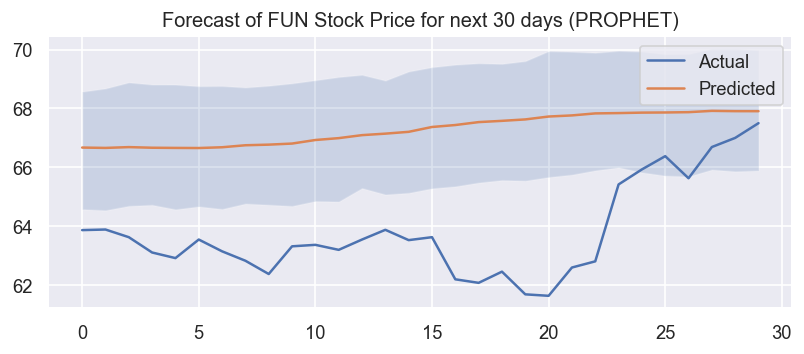

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2705.686, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2696.040, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2706.903, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2707.207, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2698.038, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2705.532, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2707.326, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2705.725, Time=1.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2705.947, Time=2.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2703.887, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2707.915, Time=1.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2705.413, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2705.844, Time=1.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2703.566, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0

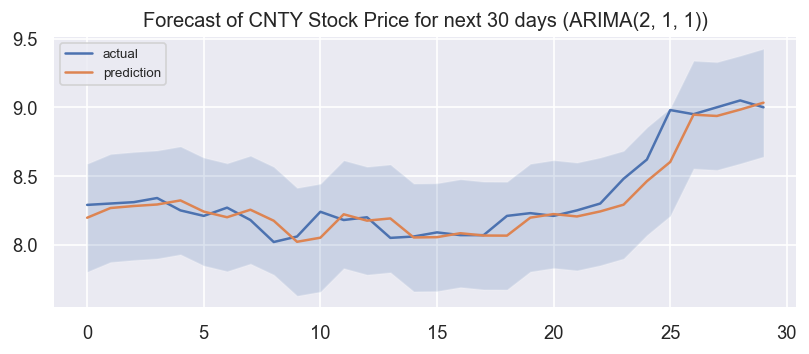

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -193.01
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6662.71     0.0282444       1067.24       0.794       0.794      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7168.71    0.00678012       1266.66           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7303.88    0.00207181        257.19           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7349.53     0.0182431        293.81      0.7233      0.7233      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7375.22     0.0134316       465.257           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  7.497802    6.800575    8.004816     7.497802     7.497802   
1  2017-10-03  7.499758    6.828662    8.054028     7.499758     7.499758   
2  2017-10-04  7.501714    6.876547    8.054287     7.501714     7.501714   
3  2017-10-05  7.503671    6.853570    8.020517     7.503671     7.503671   
4  2017-10-06  7.505627    6.871575    8.066478     7.505627     7.505627   
5  2017-10-09  7.511495    6.885598    8.057748     7.511495     7.511495   
6  2017-10-10  7.513452    6.939972    8.116700     7.513452     7.513452   
7  2017-10-11  7.515408    6.896884    8.088011     7.515408     7.515408   
8  2017-10-12  7.517364    6.970835    8.144255     7.517364     7.517364   
9  2017-10-13  7.519320    6.933862    8.131944     7.519320     7.519320   
10 2017-10-16  7.525189    6.896710    8.118503     7.525189     7.525189   
11 2017-10-17  7.527145    6.933507    8.144176     7.527145     7.527145   

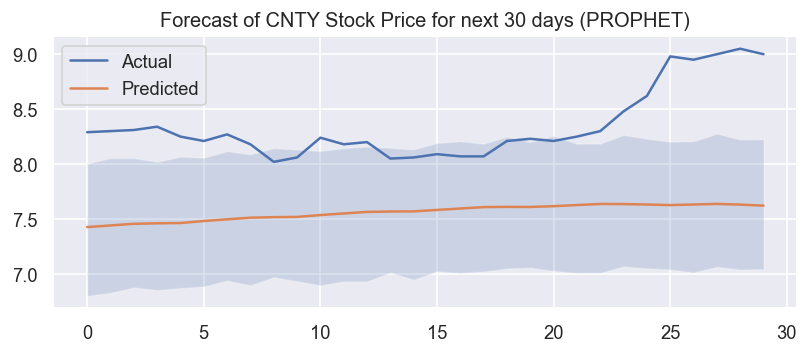

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2656.841, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24305.647, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=20309.545, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2657.586, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2657.128, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16862.356, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2659.423, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2656.872, Time=0.68 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 3.019 seconds


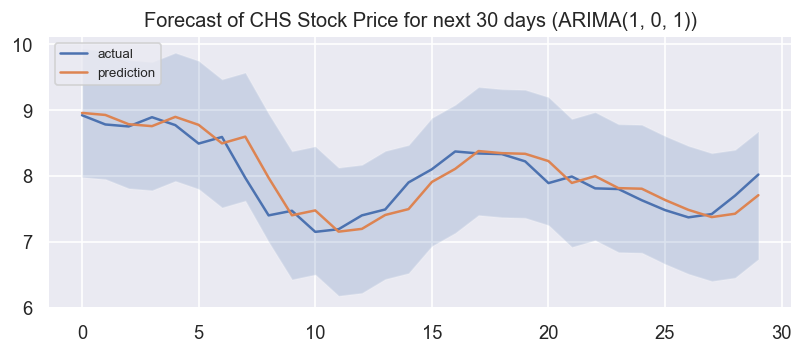

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -149.738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6870.33     0.0269406       1642.83      0.7346      0.7346      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7135.01      0.032019       929.803           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7431.97     0.0133185       704.853      0.9884      0.9884      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7566.57     0.0157856       1198.81           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7652.51    0.00340858       554.801           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  9.443163    8.018341   11.485687     9.443163     9.443163   
1  2017-10-03  9.438230    8.016286   11.605868     9.438230     9.438230   
2  2017-10-04  9.433297    7.966748   11.577580     9.433297     9.433297   
3  2017-10-05  9.428364    7.970513   11.496286     9.428364     9.428364   
4  2017-10-06  9.423432    8.059295   11.502532     9.423432     9.423432   
5  2017-10-09  9.408633    8.080009   11.364762     9.408633     9.408633   
6  2017-10-10  9.403700    8.044591   11.549406     9.403700     9.403700   
7  2017-10-11  9.398767    8.073046   11.496323     9.398767     9.398767   
8  2017-10-12  9.393834    7.922261   11.515078     9.393834     9.393834   
9  2017-10-13  9.388901    7.999461   11.565352     9.388901     9.388901   
10 2017-10-16  9.374102    7.976131   11.457312     9.374102     9.374102   
11 2017-10-17  9.369169    7.918987   11.356405     9.369169     9.369169   

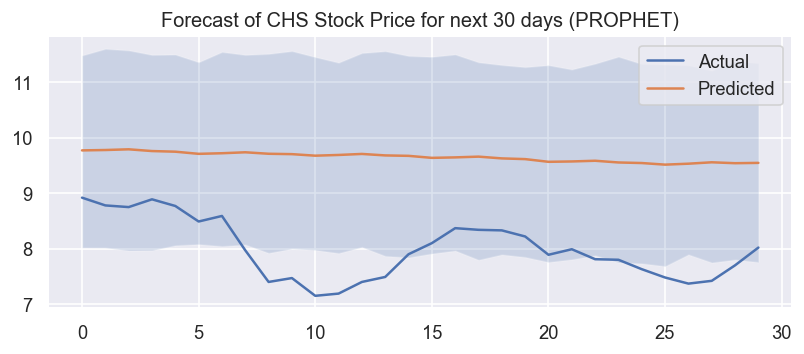

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19746.121, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19742.468, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19744.121, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19744.121, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19740.959, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.531 seconds


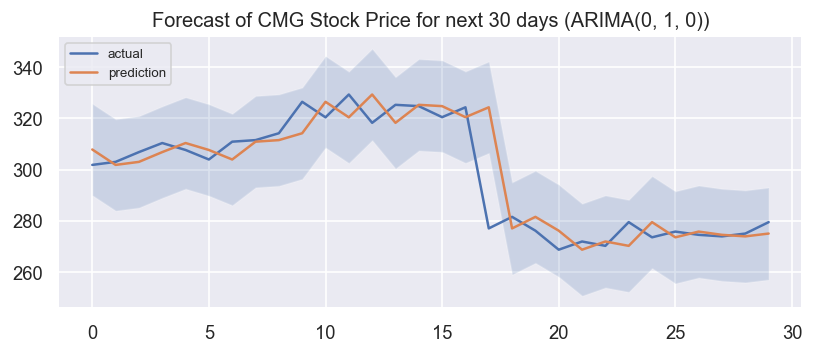

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -95.9574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6636.58     0.0206927       1765.92      0.0846           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6854.9     0.0430111       301.052           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6925.4    0.00235098       409.809           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6945.82     0.0289834       1213.66           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       6963.94   0.000173676       236.656   2.725e-07       0.001      611  LS failed, Hessian reset 
     499       6966.69    0.00546635    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  317.801247  271.384021  368.426687   317.801247   317.801247   
1  2017-10-03  317.424800  273.406928  363.956075   317.424800   317.424800   
2  2017-10-04  317.048352  269.507505  363.928192   317.048352   317.048352   
3  2017-10-05  316.671905  270.578171  365.069139   316.671905   316.671905   
4  2017-10-06  316.295458  272.123335  366.144955   316.295458   316.295458   
5  2017-10-09  315.166116  267.673970  365.147209   315.166116   315.166116   
6  2017-10-10  314.789669  268.537575  361.952677   314.789669   314.789669   
7  2017-10-11  314.413221  270.913227  359.807701   314.413221   314.413221   
8  2017-10-12  314.036774  262.276098  358.867980   314.036774   314.036774   
9  2017-10-13  313.660327  269.161618  364.557800   313.660327   313.660327   
10 2017-10-16  312.530985  265.184028  357.330498   312.530985   312.530985   
11 2017-10-17  312.154538  259.745917  356.831188   

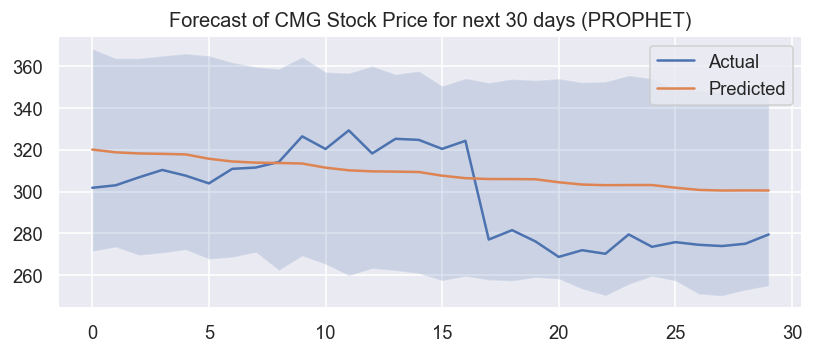

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9598.774, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9603.808, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9599.065, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9598.585, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9608.302, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9597.720, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9599.539, Time=0.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9599.351, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9601.314, Time=1.54 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9603.374, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.311 seconds


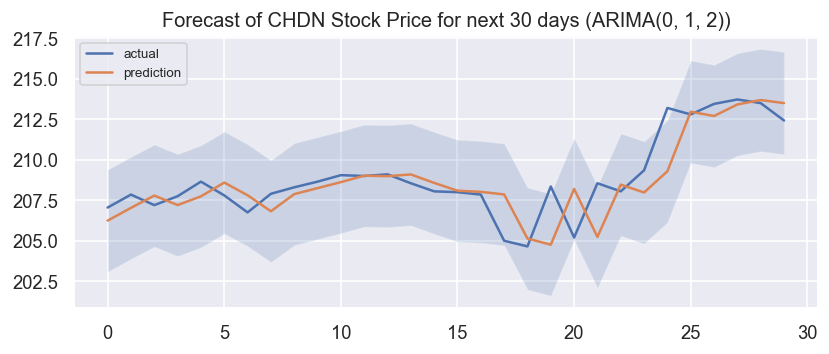

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -105.636
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8769.83     0.0128396       747.551       0.967       0.967      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8858.26     0.0107139          2337           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8892.14     0.0168687       356.453           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8910.69    0.00198482        299.94           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8918.26   0.000495565       329.797      0.7309      0.7309      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  176.739452  170.628647  185.448958   176.739452   176.739452   
1  2017-10-03  176.808771  170.770816  186.031166   176.808771   176.808771   
2  2017-10-04  176.878090  170.521262  185.784982   176.878090   176.878090   
3  2017-10-05  176.947408  171.135595  185.678460   176.947408   176.947408   
4  2017-10-06  177.016727  169.993659  185.846998   177.016727   177.016727   
5  2017-10-09  177.224684  170.207114  185.277410   177.224684   177.224684   
6  2017-10-10  177.294003  169.657339  184.709906   177.294003   177.294003   
7  2017-10-11  177.363321  170.561248  184.506512   177.363321   177.363321   
8  2017-10-12  177.432640  169.713685  184.477164   177.432640   177.432640   
9  2017-10-13  177.501959  170.022310  184.481135   177.501959   177.501959   
10 2017-10-16  177.709916  169.558004  184.489369   177.709916   177.709916   
11 2017-10-17  177.779235  169.931455  184.528284   

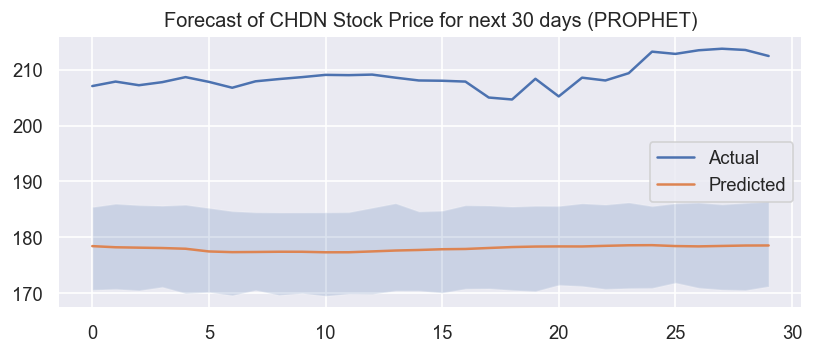

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6886.895, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6891.473, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6892.858, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6892.837, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6889.703, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6887.626, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6887.704, Time=1.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6893.920, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6894.057, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6890.102, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6885.230, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6891.074, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6891.095, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6885.962, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]          

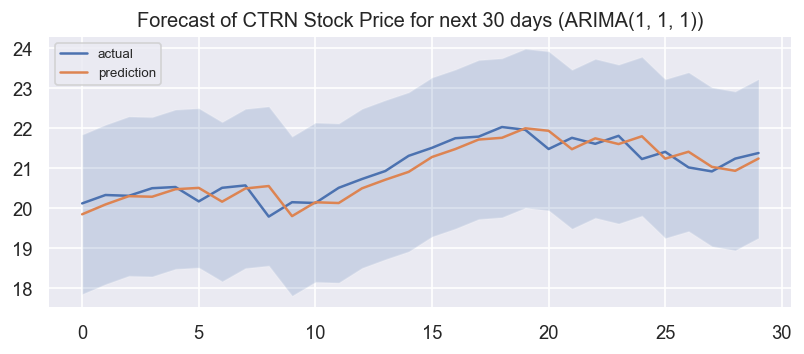

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -68.1983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6134.63     0.0336805       1890.08           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6291.73     0.0140822       1132.73      0.3828      0.3828      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6385.44     0.0458586       317.078           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6442.07      0.105442       1228.71      0.1491           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6464.48     0.0386238       867.322           1           1      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  16.334877   12.650513   20.122888    16.334877    16.334877   
1  2017-10-03  16.328222   12.536562   20.103968    16.328222    16.328222   
2  2017-10-04  16.321566   12.262587   19.992831    16.321566    16.321566   
3  2017-10-05  16.314911   12.330686   19.817656    16.314911    16.314911   
4  2017-10-06  16.308255   12.214431   19.866576    16.308255    16.308255   
5  2017-10-09  16.288289   12.329878   19.741716    16.288289    16.288289   
6  2017-10-10  16.281634   12.138010   19.811833    16.281634    16.281634   
7  2017-10-11  16.274978   12.396098   19.849566    16.274978    16.274978   
8  2017-10-12  16.268323   12.244184   19.651087    16.268323    16.268323   
9  2017-10-13  16.261667   12.058650   19.639200    16.261667    16.261667   
10 2017-10-16  16.241701   12.042926   19.508817    16.241701    16.241701   
11 2017-10-17  16.235046   12.290024   19.672038    16.235046   

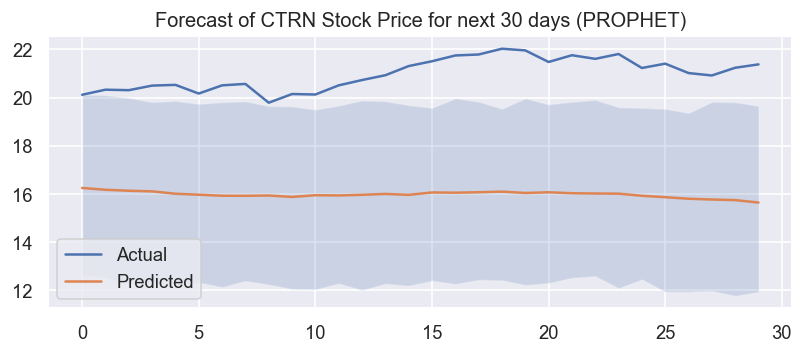

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1711.557, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1706.438, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1704.921, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1704.918, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1708.429, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1700.965, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1700.954, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1702.951, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1702.969, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1707.567, Time=1.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1713.530, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1706.908, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1706.912, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1702.955, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0

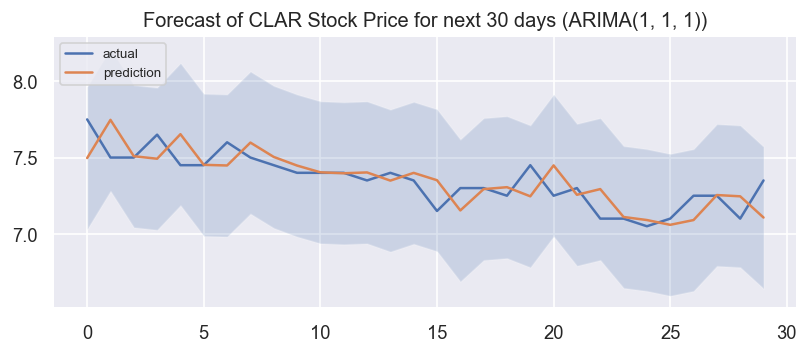

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -40.562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5956.57     0.0827347       1936.25           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6136.82     0.0359706       1097.97       0.233           1      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6192.19     0.0266628       921.112      0.7303      0.7303      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6204.17    0.00584492       133.932           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       6212.36   9.28152e-05       89.3226   5.243e-07       0.001      575  LS failed, Hessian reset 
     474       6214.06   0.000145045     

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  5.234036    3.587278    6.146391     5.234036     5.234036   
1  2017-10-03  5.231999    3.446546    6.019502     5.231999     5.231999   
2  2017-10-04  5.229962    3.552459    5.883697     5.229962     5.229962   
3  2017-10-05  5.227926    3.650785    5.984391     5.227926     5.227926   
4  2017-10-06  5.225889    3.557436    5.949966     5.225889     5.225889   
5  2017-10-09  5.219780    3.644665    6.135998     5.219780     5.219780   
6  2017-10-10  5.217743    3.652420    6.116606     5.217743     5.217743   
7  2017-10-11  5.215706    3.711970    6.181704     5.215706     5.215706   
8  2017-10-12  5.213670    3.725323    6.236487     5.213670     5.213670   
9  2017-10-13  5.211633    3.672323    6.198017     5.211633     5.211633   
10 2017-10-16  5.205524    3.718235    6.205949     5.205524     5.205524   
11 2017-10-17  5.203487    3.791896    6.228124     5.203487     5.203487   

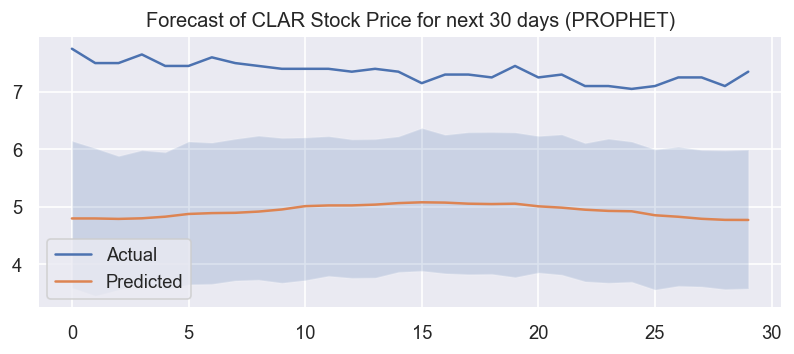

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6248.580, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6245.337, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6247.329, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6247.329, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6244.485, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.135 seconds


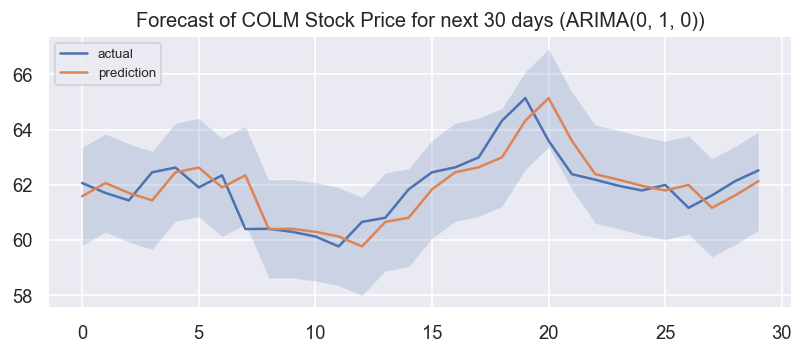

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -49.2574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7518.64     0.0772954       2159.83           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7777.23     0.0110796       856.253           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7924.48     0.0167814       1693.11      0.3748           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7954.71     0.0177799       409.577           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       7956.23   6.02852e-05        190.03   3.061e-07       0.001      516  LS failed, Hessian reset 
     499       7967.77   0.000758031    

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  56.584816   53.065155   59.545167    56.584816    56.584816   
1  2017-10-03  56.585836   53.075055   59.375716    56.585836    56.585836   
2  2017-10-04  56.586855   53.037111   59.143087    56.586855    56.586855   
3  2017-10-05  56.587874   52.943680   59.008609    56.587874    56.587874   
4  2017-10-06  56.588894   52.894256   59.023787    56.588894    56.588894   
5  2017-10-09  56.591952   52.731501   58.996129    56.591952    56.591952   
6  2017-10-10  56.592972   52.707591   58.803256    56.592972    56.592972   
7  2017-10-11  56.593991   52.531457   58.761787    56.593991    56.593991   
8  2017-10-12  56.595011   52.671879   58.786201    56.595011    56.595011   
9  2017-10-13  56.596030   52.519134   58.653166    56.596030    56.596030   
10 2017-10-16  56.599088   52.447120   58.815040    56.599088    56.599088   
11 2017-10-17  56.600108   52.245553   58.837869    56.600108   

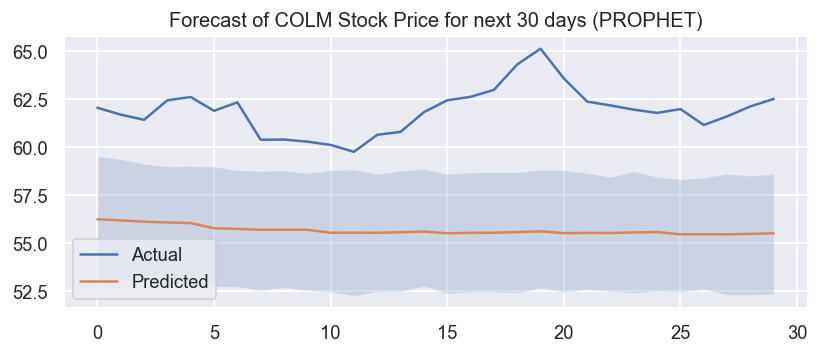

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5982.478, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5980.439, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5980.550, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5980.536, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5978.474, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds


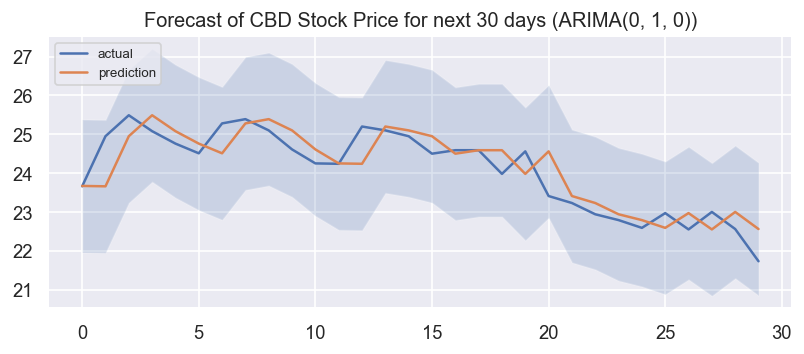

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -100.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5626.91     0.0399354       1167.79           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5827.26     0.0191581       397.459           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5965.47     0.0160765       637.483      0.3338           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6015.28     0.0386212        510.28           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6059.96    0.00987059       354.461      0.4138      0.4138      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  17.429785   11.763767   20.823099    17.429785    17.429785   
1  2017-10-03  17.428613   11.958931   20.908252    17.428613    17.428613   
2  2017-10-04  17.427440   11.985289   21.027951    17.427440    17.427440   
3  2017-10-05  17.426268   11.995504   20.776352    17.426268    17.426268   
4  2017-10-06  17.425095   12.353279   20.884640    17.425095    17.425095   
5  2017-10-09  17.421578   12.006858   21.035489    17.421578    17.421578   
6  2017-10-10  17.420405   12.113761   21.252498    17.420405    17.420405   
7  2017-10-11  17.419233   12.253768   21.381271    17.419233    17.419233   
8  2017-10-12  17.418060   12.097213   20.916271    17.418060    17.418060   
9  2017-10-13  17.416888   12.351356   21.379501    17.416888    17.416888   
10 2017-10-16  17.413370   12.458726   21.511426    17.413370    17.413370   
11 2017-10-17  17.412197   12.917345   21.514180    17.412197   

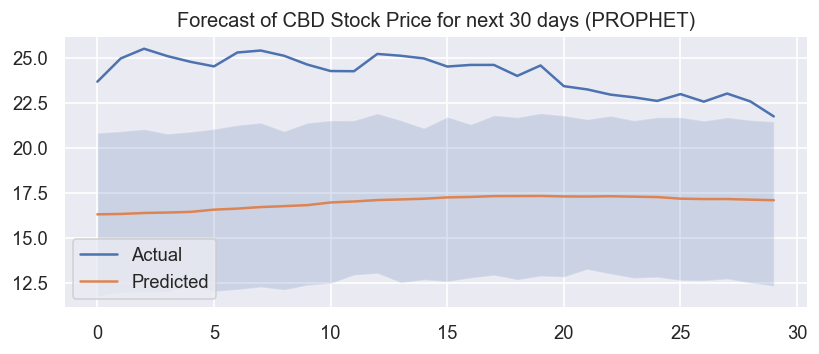

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9144.657, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9141.592, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9142.938, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9142.912, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9143.570, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.742 seconds


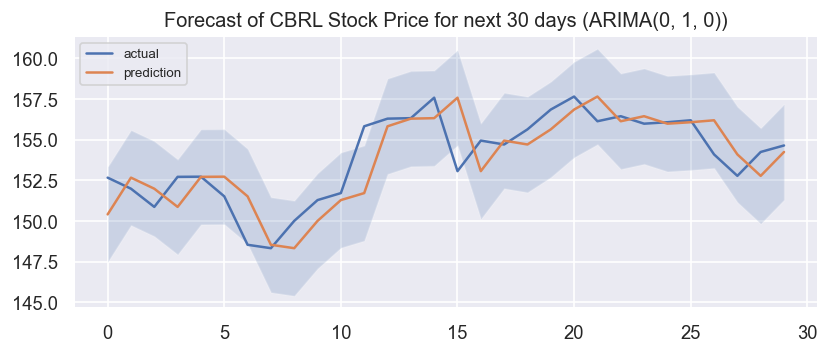

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -53.306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7988.9    0.00207968       1080.75           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8139.35    0.00231164        1057.8      0.1937           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8241.66     0.0298746       887.733           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8289.65     0.0449147       1662.61           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8324.94    0.00246902       274.115      0.9555      0.9555      570   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  157.609921  150.019156  161.692429   157.609921   157.609921   
1  2017-10-03  157.650663  149.900737  162.292412   157.650663   157.650663   
2  2017-10-04  157.691405  149.989575  161.975585   157.691405   157.691405   
3  2017-10-05  157.732147  149.572107  161.999843   157.732147   157.732147   
4  2017-10-06  157.772889  149.954340  162.454447   157.772889   157.772889   
5  2017-10-09  157.895116  149.733124  161.432727   157.895116   157.895116   
6  2017-10-10  157.935858  149.875361  162.215056   157.935858   157.935858   
7  2017-10-11  157.976600  149.373942  162.267885   157.976600   157.976600   
8  2017-10-12  158.017342  149.827772  162.356761   158.017342   158.017342   
9  2017-10-13  158.058084  149.736357  162.253996   158.058084   158.058084   
10 2017-10-16  158.180311  149.719678  161.508821   158.180311   158.180311   
11 2017-10-17  158.221053  149.221117  161.942166   

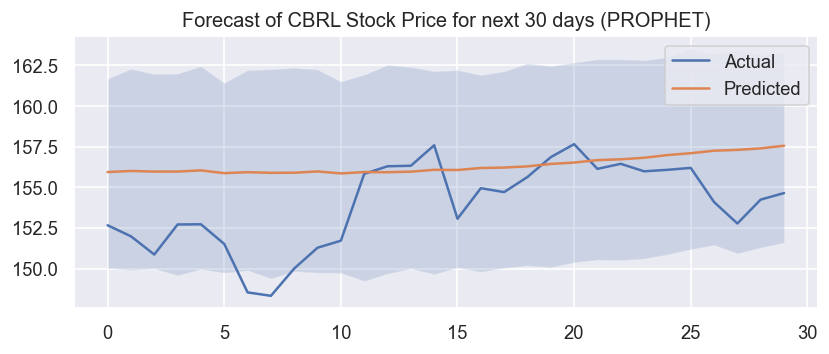

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4641.042, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29943.432, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4641.925, Time=0.59 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=22268.772, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4640.665, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19460.683, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4641.694, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4641.590, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23376.344, Time=0.

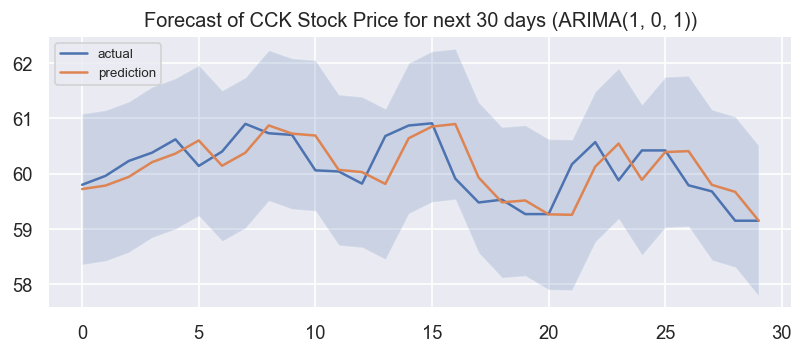

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.7624
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       8073.76     0.0122213       843.328           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8169.32     0.0156107       452.322      0.2823           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8221.91    0.00159768       592.758           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          8305     0.0664282       2370.23       7.842      0.7842      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8360.01      0.022799       537.739           1           1      583   
  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  56.537210   52.855621   57.427999    56.537210    56.537210   
1  2017-10-03  56.544225   52.717060   57.427477    56.544225    56.544225   
2  2017-10-04  56.551239   52.761385   57.429354    56.551239    56.551239   
3  2017-10-05  56.558254   52.687104   57.538205    56.558254    56.558254   
4  2017-10-06  56.565269   52.830506   57.542596    56.565269    56.565269   
5  2017-10-09  56.586313   52.922572   57.600355    56.586313    56.586313   
6  2017-10-10  56.593327   52.934010   57.468534    56.593327    56.593327   
7  2017-10-11  56.600342   52.923660   57.820991    56.600342    56.600342   
8  2017-10-12  56.607357   52.694712   57.762081    56.607357    56.607357   
9  2017-10-13  56.614371   53.233863   57.739146    56.614371    56.614371   
10 2017-10-16  56.635415   53.163376   57.955257    56.635415    56.635415   
11 2017-10-17  56.642430   53.501847   58.023427    56.642430   

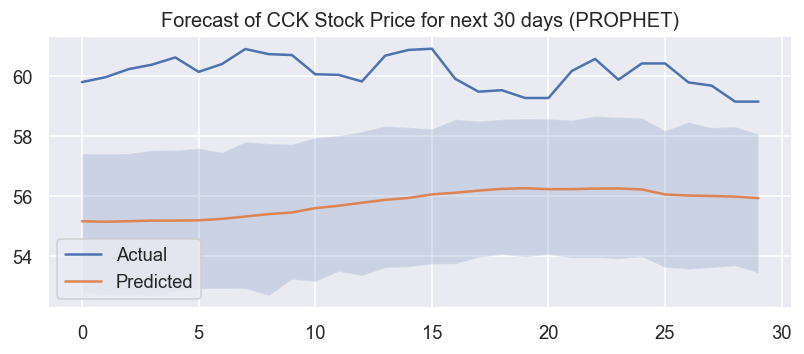

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2016.740, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2020.122, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2018.253, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2018.550, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2020.506, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2017.308, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2017.293, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2015.295, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2017.293, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2019.254, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2015.645, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.548 seconds


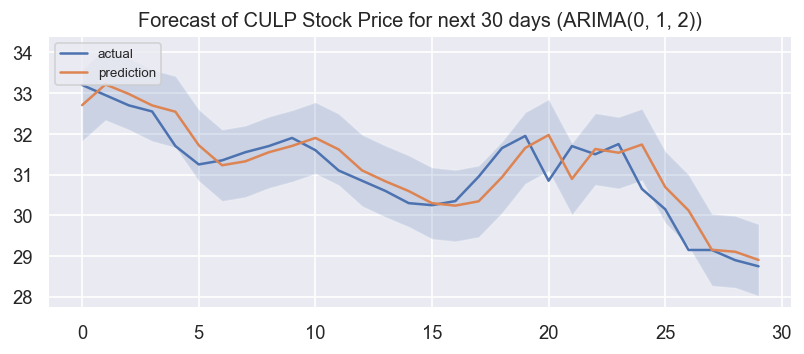

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -43.4184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7102.09     0.0268808       1138.49           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7305.54     0.0924613       2183.29           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7428.09      0.354504       2616.52           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7516.46    0.00267339       422.634           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7547.17     0.0219362       692.578           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  32.268447   30.240306   34.099622    32.268447    32.268447   
1  2017-10-03  32.275446   30.334469   33.985283    32.275446    32.275446   
2  2017-10-04  32.282445   30.137742   34.086467    32.282445    32.282445   
3  2017-10-05  32.289444   30.228335   34.162882    32.289444    32.289444   
4  2017-10-06  32.296443   30.303329   34.046077    32.296443    32.296443   
5  2017-10-09  32.317440   30.312540   34.016353    32.317440    32.317440   
6  2017-10-10  32.324439   30.209626   34.048209    32.324439    32.324439   
7  2017-10-11  32.331438   30.228451   33.948232    32.331438    32.331438   
8  2017-10-12  32.338437   30.216540   34.015140    32.338437    32.338437   
9  2017-10-13  32.345436   30.209567   33.936264    32.345436    32.345436   
10 2017-10-16  32.366433   30.204086   34.037920    32.366433    32.366433   
11 2017-10-17  32.373432   30.258438   33.977973    32.373432   

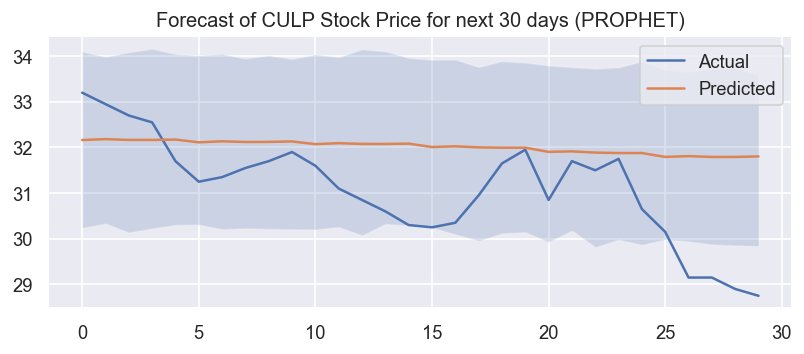

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6027.578, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6026.943, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6027.395, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6027.298, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6026.919, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.142 seconds


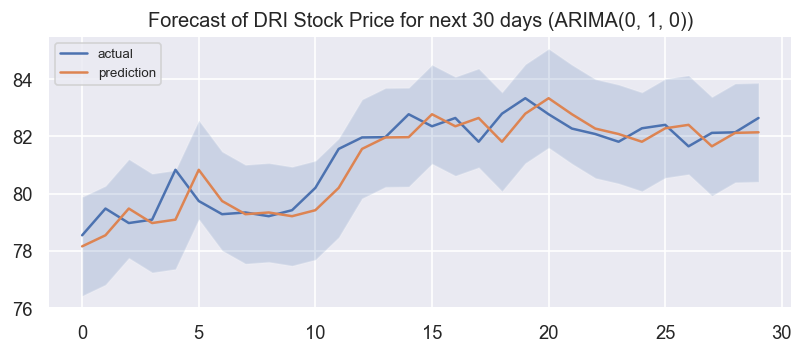

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -48.0443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8316.25    0.00976432       398.395           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8378.63     0.0208769       2206.36           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8399.03   0.000478802       115.739           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8411.03   0.000724185       688.522      0.2858      0.2858      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8414.08   0.000156976       186.279      0.4972      0.4972      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  82.741003   78.102473   85.971272    82.741003    82.741003   
1  2017-10-03  82.777393   78.176444   86.028197    82.777393    82.777393   
2  2017-10-04  82.813782   77.997920   85.713870    82.813782    82.813782   
3  2017-10-05  82.850171   77.892192   86.031897    82.850171    82.850171   
4  2017-10-06  82.886561   77.784272   85.895108    82.886561    82.886561   
5  2017-10-09  82.995729   77.867174   85.958124    82.995729    82.995729   
6  2017-10-10  83.032119   78.205833   86.011513    83.032119    83.032119   
7  2017-10-11  83.068508   78.231114   85.783926    83.068508    83.068508   
8  2017-10-12  83.104898   77.885557   85.639419    83.104898    83.104898   
9  2017-10-13  83.141287   78.051718   85.885634    83.141287    83.141287   
10 2017-10-16  83.250455   77.828090   86.050748    83.250455    83.250455   
11 2017-10-17  83.286845   77.982075   85.427258    83.286845   

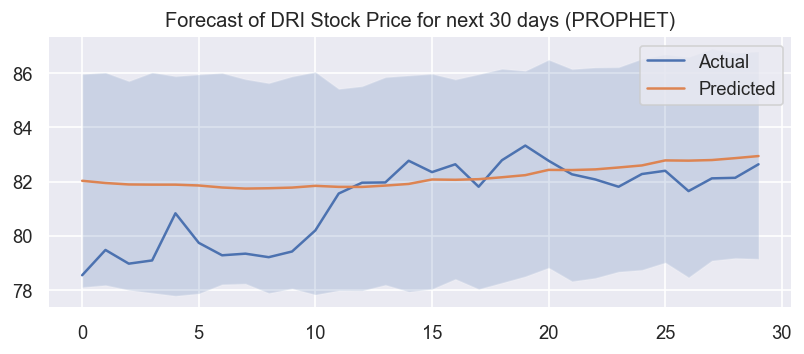

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2966.242, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2973.419, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2965.458, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2965.605, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2971.493, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2967.334, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2967.094, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2963.539, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2965.414, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2964.319, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2963.687, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2965.174, Time=0.49 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.220 seconds


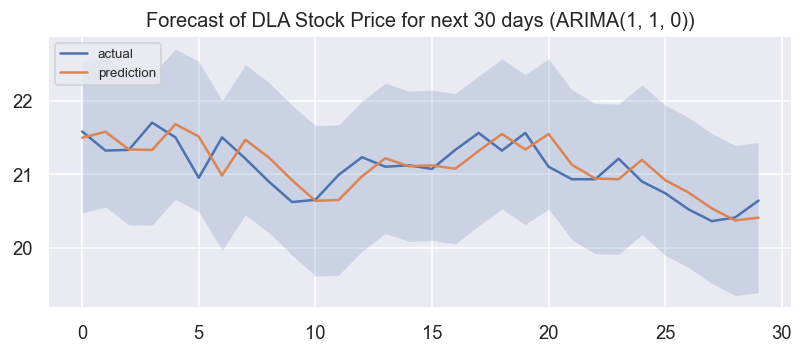

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -88.8701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5536.02     0.0873968       1468.59      0.2373           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5690.53       0.12297       461.358       1.397      0.1397      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       5728.64   0.000262234       218.124   1.498e-06       0.001      385  LS failed, Hessian reset 
     299       5729.26   0.000475077       286.624      0.5689      0.5689      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       5736.06   0.000173105       154.601   7.861e-07       0.001      445  LS failed, Hessian reset 
     399       5755.14     0.0126374       172.775           1           1      540   
    Iter      log pro

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  21.254545   19.841139   24.381119    21.254545    21.254545   
1  2017-10-03  21.264073   19.695374   24.294001    21.264073    21.264073   
2  2017-10-04  21.273601   19.986910   24.269701    21.273601    21.273601   
3  2017-10-05  21.283129   19.865116   24.325518    21.283129    21.283129   
4  2017-10-06  21.292657   19.903166   24.377452    21.292657    21.292657   
5  2017-10-09  21.321240   20.064899   24.477592    21.321240    21.321240   
6  2017-10-10  21.330768   19.833279   24.639364    21.330768    21.330768   
7  2017-10-11  21.340296   20.088596   24.454457    21.340296    21.340296   
8  2017-10-12  21.349824   20.081674   24.468079    21.349824    21.349824   
9  2017-10-13  21.359352   19.979459   24.471736    21.359352    21.359352   
10 2017-10-16  21.387936   20.087077   24.548889    21.387936    21.387936   
11 2017-10-17  21.397464   20.052270   24.482472    21.397464   

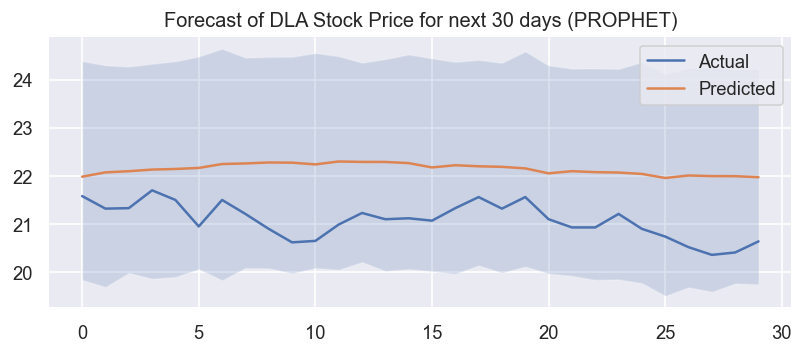

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1970.138, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1954.866, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1955.490, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1955.731, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1956.662, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1960.059, Time=1.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1970.123, Time=2.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1959.894, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1958.542, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1969.087, Time=1.73 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1971.784, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1957.512, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1957.273, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1971.866, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0

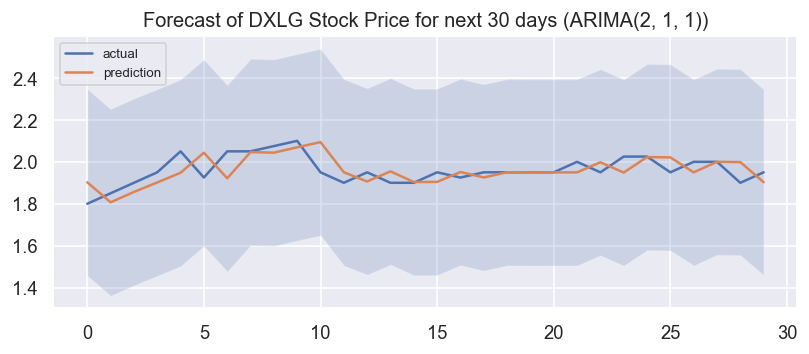

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -56.217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6181.56     0.0683165       6911.46           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7014.68   0.000856865       654.537      0.5643      0.5643      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7139.49      0.020869       1447.16           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7338.41     0.0924997       2377.42      0.4871           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7392.01     0.0285677       378.898           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/pallavibothra/opt/anaconda3/envs/prophet39/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2017-10-02  2.141662    2.141473    3.680263     2.141662     2.141662   
1  2017-10-03  2.137852    2.225708    3.665164     2.137852     2.137852   
2  2017-10-04  2.134042    2.168280    3.625744     2.134042     2.134042   
3  2017-10-05  2.130231    2.175373    3.600831     2.130231     2.130231   
4  2017-10-06  2.126421    2.154394    3.632296     2.126421     2.126421   
5  2017-10-09  2.114990    2.168637    3.565875     2.114990     2.114990   
6  2017-10-10  2.111179    2.130180    3.539728     2.111179     2.111179   
7  2017-10-11  2.107369    2.132330    3.491763     2.107369     2.107369   
8  2017-10-12  2.103559    2.128845    3.505812     2.103559     2.103559   
9  2017-10-13  2.099748    2.067986    3.604459     2.099748     2.099748   
10 2017-10-16  2.088317    2.091946    3.481807     2.088317     2.088317   
11 2017-10-17  2.084507    2.064552    3.488116     2.084507     2.084507   

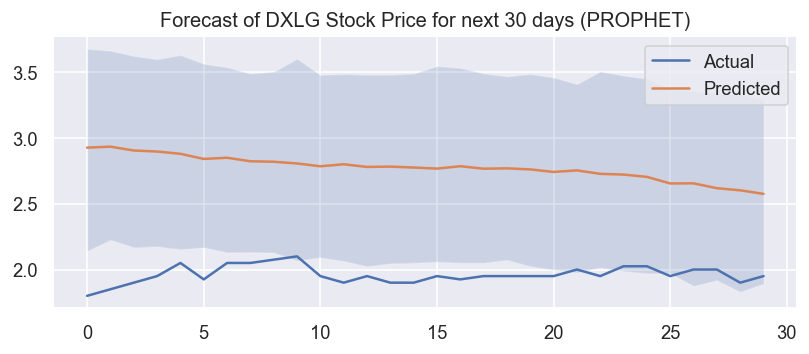

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6751.682, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6754.605, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6751.888, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6751.563, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6752.676, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6750.752, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6752.722, Time=0.98 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6752.688, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6750.092, Time=1.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6745.915, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6754.036, Time=1.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6754.216, Time=2.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6746.220, Time=2.17 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6743.995, Time=0.74 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [ ]:
start = time.time()
keys_list = []
PMDARIMA_RMSE_list = []
PMDARIMA_MAPE_list = []
PROPHET_RMSE_list = []
PROPHET_MAPE_list = []
for keys in cons_cyc_df_years:
    try:
        Company_df = cons_cyc_df_years[keys][['Close']]
        pmdarima_model = pmdarima_model_eval(Company_df,keys)
        prophet_model = prophet_model_eval(Company_df,keys)
        keys_list.append(keys)
        PMDARIMA_RMSE_list.append(pmdarima_model[1])
        PMDARIMA_MAPE_list.append(pmdarima_model[2])
        PROPHET_RMSE_list.append(prophet_model[1])
        PROPHET_MAPE_list.append(prophet_model[2])
    except KeyError:
        pass
    
    
eval_metrics = pd.DataFrame({'Company' : keys_list ,'PMDARIMA_RMSE' : PMDARIMA_RMSE_list,'PMDARIMA_MAPE' :PMDARIMA_MAPE_list , 'Prophet_RMSE': PROPHET_RMSE_list,'Prophet_MAPE' : PROPHET_MAPE_list})
end = time.time()
print('total_time: {} mins {} secs'.format(int((end - start)/60), int(end - start)%60))


In [434]:
eval_metrics_final = eval_metrics.copy()

In [435]:
eval_metrics_final

Company  PMDARIMA_RMSE  PMDARIMA_MAPE  Prophet_RMSE  Prophet_MAPE
0       AAN       0.911358       0.016202      9.710925      0.220906
1       ANF       0.394411       0.020395      3.914968      0.288544
2       AAP       1.616379       0.013680     42.845225      0.496572
3       AIN       0.871488       0.008481      8.165627      0.139757
4      AMZN      24.781994       0.010127     57.682643      0.052654
..      ...            ...            ...           ...           ...
147    URBN       0.429364       0.014140      3.291062      0.124189
148     MTN       2.333392       0.007986     12.324862      0.048944
149     WWW       0.533592       0.013525      5.957204      0.209443
150    WYNN       2.012363       0.009610     27.985402      0.188560
151     YUM       1.069597       0.007771      6.900455      0.086286

[152 rows x 5 columns]

In [25]:
eval_metrics.nsmallest(columns ='PMDARIMA_MAPE',n = 5).reset_index(drop= True)

Company  PMDARIMA_RMSE  PMDARIMA_MAPE  Prophet_RMSE  Prophet_MAPE
0      HD       0.935167       0.004154     12.346563      0.074378
1    CHDN       1.498775       0.004915     30.911472      0.147477
2     IHG       0.381484       0.005273      5.553494      0.098873
3     CCK       0.435401       0.005526      4.383031      0.071684
4     MCD       1.253783       0.005906     15.886949      0.094600